In [1]:
import os
import sys

# choose the GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# disable preallocation of memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# pcx
import pcx as px
import pcx.predictive_coding as pxc
import pcx.nn as pxnn
import pcx.functional as pxf
import pcx.utils as pxu

# 3rd party
import jax
from jax import jit
import jax.numpy as jnp
import jax.numpy.linalg as jax_la
import jax.random as random
import optax
import numpy as np
import pandas as pd
from pandas.api.types import is_float_dtype
from ucimlrepo import fetch_ucirepo 

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
import timeit

# own
import causal_helpers
from causal_helpers import simulate_dag, simulate_parameter, simulate_linear_sem, simulate_linear_sem_cyclic
from causal_helpers import load_adjacency_matrix, set_random_seed, plot_adjacency_matrices
from causal_helpers import load_graph, load_adjacency_matrix
from causal_metrics import compute_F1_directed, compute_F1_skeleton, compute_AUPRC, compute_AUROC, compute_model_fit
from causal_metrics import compute_cycle_F1, compute_cycle_SHD, compute_cycle_KLD, compute_CSS  # CSS: Cyclic Structure Score
from connectome_cyclic_data_generator import sample_cyclic_data

# dglearn
sys.path.append('/home/amine.mcharrak/clear2025/')  # Add parent directory of `dglearn`
from dglearn.dg.adjacency_structure import AdjacencyStucture  # Ensure class name matches exactly
from dglearn.dg.graph_equivalence_search import GraphEquivalenceSearch
from dglearn.dg.converter import binary2array
from dglearn.learning.cyclic_manager import CyclicManager
from dglearn.dg.reduction import reduce_support
from dglearn.learning.search.virtual import virtual_refine
from dglearn.learning.search.tabu import tabu_search

# lingd
from lingd import LiNGD

frp_path = '/home/amine.mcharrak/frp'
if frp_path not in sys.path:
    sys.path.insert(0, frp_path)

# Now you can safely import the required functions
from run_causal_discovery import run_filter_rank_prune, run_dglearn

# Set random seed
#seed = 44 # main seed for reproducibility
seed = 33
set_random_seed(seed)

# causal libraries
import cdt, castle

# causal metrics
from cdt.metrics import precision_recall, SHD, SID
from castle.metrics import MetricsDAG
from castle.common import GraphDAG
from causallearn.graph.SHD import SHD as SHD_causallearn

/share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Final sys.path:
/home/amine.mcharrak/frp/dglearn
/home/amine.mcharrak/frp
/home/amine.mcharrak/causality-lab
/home/amine.mcharrak/dodiscover
/home/amine.mcharrak/cosmo
/home/amine.mcharrak/cadimulc
/home/amine.mcharrak/clear2025/nodags-flows
/share/amine.mcharrak/miniconda3/envs/pcax24/lib/python310.zip
/share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10
/share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/lib-dynload

/share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages
/home/amine.mcharrak/pcax
/home/amine.mcharrak/clear2025/
CyclicManager is imported from: /home/amine.mcharrak/frp/frp_dglearn/learning/cyclic_manager.py


Detecting CUDA device(s) : [0]


In [2]:
import os

#   # fetch dataset 
# abalone = fetch_ucirepo(id=1) 
  
# # data (as pandas dataframes) 
# X = abalone.data.features
# y = abalone.data.targets
  
# # metadata 
# #print(abalone.metadata) 

# # now merge X and y to create a single dataframe and give the columns the correct names using abalone.variables.name.values
# df = pd.concat([X, y], axis=1)
# df.columns = abalone.variables.name.values.tolist()
# print(df.head())
# print()
# # show # of unique values in each column
# print(df.nunique())
# # finally convert the Rings variable to a binary variable by setting the threshold to mean(rings)
# df['Rings'] = df['Rings'] > df['Rings'].mean()
# # then convert to integer
# df['Rings'] = df['Rings'].astype(int)
# # also replace the values in Sex with integers
# df['Sex'] = df['Sex'].map({'M': 0, 'F': 1, 'I': 2})

# # now show the first 5 rows of the dataframe
# print(df.head())

# # Create a boolean list for continuous variables (any float dtype)
# is_cont_node = df.dtypes.map(is_float_dtype).tolist()

# # Print the result
# print(is_cont_node)

# # plot the distribution of all variables in the dataframe
# df.hist(figsize=(15, 10))
# plt.show()

# paths to different datasets

# 10 nodes ER
#path = '../data/linear_cyclic_exp_er_nvars_10_max_degree_5_max_cycle_3_n_samples_5000/'
#path = '../data/linear_cyclic_gauss-ev_er_nvars_10_max_degree_5_max_cycle_3_n_samples_5000/'
#path = '../data/linear_cyclic_softplus_er_nvars_10_max_degree_5_max_cycle_3_n_samples_5000/'
#path = '../data/linear_cyclic_uniform_er_nvars_10_max_degree_5_max_cycle_3_n_samples_5000/'

# 10 nodes SF
#path = '../data/linear_cyclic_exp_sf_nvars_10_max_degree_5_max_cycle_3_n_samples_5000/'
path = '../data/linear_cyclic_gauss-ev_sf_nvars_10_max_degree_5_max_cycle_3_n_samples_5000/'
#path = '../data/linear_cyclic_softplus_sf_nvars_10_max_degree_5_max_cycle_3_n_samples_5000/'
#path = '../data/linear_cyclic_uniform_sf_nvars_10_max_degree_5_max_cycle_3_n_samples_5000/'


# load adjacency matrix and data as pandas dataframe, both files have no header
adj_matrix = pd.read_csv(path + 'adj_matrix.csv', header=None)
data = pd.read_csv(path + 'train.csv', header=None)
weighted_adj_matrix = pd.read_csv(path + 'W_adj_matrix.csv', header=None)
prec_matrix_path = os.path.join(path, 'prec_matrix.csv')
if os.path.exists(prec_matrix_path):
    prec_matrix = pd.read_csv(prec_matrix_path, header=None)
n_vars = data.shape[1]

B_true = adj_matrix.values
X = data.values
W_true = weighted_adj_matrix.values

# get edge list from B_true using networkx
G_true = nx.DiGraph(B_true)
edges_list= list(G_true.edges())
# compute performance metric: SHD
true_graph = AdjacencyStucture(n_vars=n_vars, edge_list=edges_list)
search = GraphEquivalenceSearch(true_graph)
search.search_dfs()
B_true_EC = [binary2array(bstr) for bstr in search.visited_graphs]
print("Size of equivalence class of true graph: ", len(B_true_EC))
# check if G_true is cyclic by listing all cycles
print("Number of cycles in G_true: ", len(list(nx.simple_cycles(G_true))))

Found 1000 equivalent graphs
Found 2000 equivalent graphs
Size of equivalence class of true graph:  2124
Number of cycles in G_true:  2


In [3]:
data.head()
# show unique values in each column
print(data.nunique())
# Determine if each variable is continuous or discrete based on the number of unique values
is_cont_node = np.array([True if data[col].nunique() > 2 else False for col in data.columns])
is_cont_node = is_cont_node.tolist()
print(is_cont_node)

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
dtype: int64
[True, True, True, True, True, True, True, True, True, True]


In [4]:
# # ## Load the actual connectome data

# # %%
# # load the weighted adjacency matrices for ER and connectome

# # Specify the folder where the adjacency matrices were saved
# folder = '../data/'

# # Specify the folder where the acyclic positive integer weighted connectome data was saved
# folder_cyclic = '/home/amine.mcharrak/connectome/data/'
# # Specify the folder where the acyclic positive integer weighted connectome data was saved
# folder_acyclic = '/home/amine.mcharrak/connectome/data/'

# # Example usage to load the saved adjacency matrices
# # G_A_init_t_ordered_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_adj_matrix.npy'))
# # G_A_init_t_ordered_dag_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_dag_adj_matrix.npy'))
# # ER = load_adjacency_matrix(os.path.join(folder, 'ER_adj_matrix.npy'))
# # ER_dag = load_adjacency_matrix(os.path.join(folder, 'ER_dag_adj_matrix.npy'))

# # Change name of the connectome adjacency matrix to C and C_dag
# # C = G_A_init_t_ordered_adj_matrix
# # C_dag = G_A_init_t_ordered_dag_adj_matrix

# # Now ensure that both DAG adjacency matrices are binary, if they aren't already
# # ER_dag_bin = (ER_dag != 0).astype(int)
# # C_dag_bin = (C_dag != 0).astype(int)

# # ER_true = ER_dag_bin
# # C_true = C_dag_bin

# # %% [markdown]
# # ## Create data to debug and implement the pcax version of NOTEARS

# # %%
# # actual data
# B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2
# # B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4
# # debugging data
# # B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2


# # B_true = C_dag_bin # if you want to use the connectome-based DAG # best
# #B_true = ER_dag_bin # if you want to use the ER-based DAG

# #B_true = simulate_dag(d=5, s0=10, graph_type='ER') # ER2
# #B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2
# #B_true = simulate_dag(d=50, s0=100, graph_type='ER') # ER2
# #B_true = simulate_dag(d=100, s0=200, graph_type='ER') # ER2
# #B_true = simulate_dag(d=279, s0=558, graph_type='ER') # ER2

# # create SF2 graph and SF4 graph with d=10 nodes
# #B_true = simulate_dag(d=10, s0=20, graph_type='SF') # SF2
# #B_true = simulate_dag(d=10, s0=40, graph_type='SF') # SF4
# #B_true = simulate_dag(d=100, s0=400, graph_type='SF') # SF4

# # create ER2 and ER4 graphs with d=100 nodes
# #B_true = simulate_dag(d=100, s0=200, graph_type='ER') # ER2
# #B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4

# # create equivalent ER4 and ER6 graphs
# #B_true = simulate_dag(d=279, s0=1116, graph_type='ER') # ER4
# #B_true = simulate_dag(d=279, s0=1674, graph_type='ER') # ER6

# # create equivalent SF4 and SF6 graphs
# #B_true = simulate_dag(d=100, s0=600, graph_type='SF') # SF6
# #B_true = simulate_dag(d=279, s0=1116, graph_type='SF') # SF4
# #B_true = simulate_dag(d=279, s0=1674, graph_type='SF') # SF6

# # create simple data using simulate_dag method from causal_helpers with expected number of edges (s0) and number of nodes (d)
# #B_true = simulate_dag(d=100, s0=199, graph_type='ER') # we use p≈0.040226 for the connectome-based ER_dag graph. This means that the expected number of edges is 0.040226 * d * (d-1) / 2
# # examples: d=50 -> s0=49 (works), d=100 -> s0=199, d=200 -> s0=800

# # create the weighted adjacency matrix based on the binary adjacency matrix
# #W_true = simulate_parameter(B_true, connectome=True)
# #W_true = simulate_parameter(B_true)

# # sample data from the linear SEM
# # actual data
# #X = simulate_linear_sem(W_true, n=10000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=10000, sem_type='uniform')
# # for debugging
# #X = simulate_linear_sem(W_true, n=1000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=2500, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=6250, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=50000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=100000, sem_type='gauss') # 1000*(279**2)/(20**2) = 194602

# # load the cyclic integer weighted connectome data adjacency matrix
# #B_true_weighted = load_adjacency_matrix(os.path.join(folder_cyclic, 'A_init_t_ordered_adj_matrix_with_cycles.npy'))
# #X, W_true = sample_cyclic_data(B_true_weighted, n_samples=10000, noise_type='non-gaussian')
# #B_true = (W_true != 0).astype(int)

# # load the acyclic integer weighted connectome data adjacency matrix
# # B_true_weighted = load_adjacency_matrix(os.path.join(folder_acyclic, 'A_init_t_ordered_adj_matrix_no_cycles.npy'))
# # print("B_true_weighted:\n", np.array_str(B_true_weighted, precision=4, suppress_small=True))

# # A: use this for regular DAGs
# W_true = simulate_parameter(B_true)

# # B: use this for connectome-based DAGs
# #W_true = simulate_parameter(B_true_weighted, connectome=True)
# #B_true = (W_true != 0).astype(int)

# # some print statements to check the values of W_true
# print("W_true:\n", np.array_str(W_true, precision=4, suppress_small=True))
# print("Mean of W_true:", np.mean(W_true))
# print("Variance of W_true:", np.var(W_true))
# print("Max value in W_true:", np.max(W_true))
# print("Min value in W_true:", np.min(W_true))

# # sample data from the linear SEM
# X = simulate_linear_sem(W_true, n=1000, sem_type='gauss')

# # now standardized data, where each variable is normalized to unit variance
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_std = scaler.fit_transform(X)

# # NOTE: you may not write positional arguments after keyword arguments. 
# # That is, the values that you are passing positionally have to come first!

# # create a dataset using the simulated data
# # NOTE: NOTEARS paper uses n=1000 for graph with d=20.
# # NOTE: d... number of nodes, p=d^2... number of parameters, n... number of samples. Then: comparing p1=d1^2 vs p2=d2^2 we have that: n1/p1 must be equal to n2/p2
# # Thus we have n2 = n1 * p2 / p1. For the case of d2=100 we have that n2 = (n1*p2)/p1 = 1000*(100^2)/(20^2) = 25000 
# # we should expect to use that many samples actually to be able to learn the graph in a comparable way.
# #dataset = IIDSimulation(W=W_true, n=25000, method='linear', sem_type='gauss')
# #true_dag, X = dataset.B, dataset.X

In [5]:
# print how many non-zero entries are in the true DAG
print(f"Number of non-zero entries in the true DAG: {np.count_nonzero(B_true)}")

Number of non-zero entries in the true DAG: 23


In [6]:
# utility and evaluation functions
@jit
def MAE(W_true, W):
    """This function returns the Mean Absolute Error for the difference between the true weighted adjacency matrix W_true and th estimated one, W."""
    MAE_ = jnp.mean(jnp.abs(W - W_true))
    return MAE_

@jax.jit
def compute_h_reg(W):
    """
    Compute the DAG constraint using the exponential trace-based acyclicity constraint.

    This function calculates the value of the acyclicity constraint for a given
    adjacency matrix using the formulation:
    h_reg = trace(exp(W ⊙ W)) - d
    where ⊙ represents the Hadamard (element-wise) product.

    Parameters
    ----------
    W : jnp.ndarray
        (d, d) adjacency matrix.

    Returns
    -------
    h_reg : float
        The value of the DAG constraint.
    """
    # Dimensions of W
    d = W.shape[0]

    # Compute h_reg using the trace of the matrix exponential
    h_reg = jnp.trace(jax_la.expm(jnp.multiply(W, W))) - d

    return h_reg

@jax.jit
def notears_dag_constraint(W):
    """
    Compute the NOTEARS DAG constraint using the exponential trace-based acyclicity constraint.

    This function calculates the value of the acyclicity constraint for a given
    adjacency matrix using the formulation:
    h_reg = trace(exp(W ⊙ W)) - d
    where ⊙ represents the Hadamard (element-wise) product.

    Parameters
    ----------
    W : jnp.ndarray
        (d, d) adjacency matrix.

    Returns
    -------
    h_reg : float
        The value of the DAG constraint.
    """
    # Dimensions of W
    d = W.shape[0]

    # Compute h_reg using the trace of the matrix exponential
    h_reg = jnp.trace(jax_la.expm(jnp.multiply(W, W))) - d

    return h_reg

@jax.jit
def dagma_dag_constraint(W, s=1.0):
    """
    Compute the DAG constraint using the logdet acyclicity constraint from DAGMA.
    This function is JAX-jitted for improved performance.

    Parameters
    ----------
    W : jnp.ndarray
        (d, d) adjacency matrix.
    s : float, optional
        Controls the domain of M-matrices. Defaults to 1.0.

    Returns
    -------
    h_reg : float
        The value of the DAG constraint.
    """
    # Dimensions of W
    d = W.shape[0]

    # Compute M-matrix for the logdet constraint
    M = s * jnp.eye(d) - jnp.multiply(W, W)

    # Compute the value of the logdet DAG constraint
    h_reg = -jax_la.slogdet(M)[1] + d * jnp.log(s)

    return h_reg


# Define fucntion to compute h_reg based W with h_reg = jnp.trace(jax.scipy.linalg.expm(W * W)) - d, here * denotes the hadamard product
def compute_h_reg(W):
    """This function computes the h_reg term based on the matrix W."""
    h_reg = jnp.trace(jax.scipy.linalg.expm(W * W)) - W.shape[0]
    return h_reg

def compute_binary_adjacency(W, threshold=0.3):
    """
    Compute the binary adjacency matrix by thresholding the input matrix.

    Args:
    - W (array-like): The weighted adjacency matrix (can be a JAX array or a NumPy array).
    - threshold (float): The threshold value to determine the binary matrix. Default is 0.3.

    Returns:
    - B_est (np.ndarray): The binary adjacency matrix where each element is True if the corresponding 
                          element in W is greater than the threshold, otherwise False.
    """
    # Convert JAX array to NumPy array if necessary
    if isinstance(W, jnp.ndarray):
        W = np.array(W)

    # Compute the binary adjacency matrix
    B_est = np.array(np.abs(W) > threshold)
    
    return B_est

def ensure_DAG(W):
    """
    Ensure that the weighted adjacency matrix corresponds to a DAG.

    Inputs:
        W: numpy.ndarray - a weighted adjacency matrix representing a directed graph

    Outputs:
        W: numpy.ndarray - a weighted adjacency matrix without cycles (DAG)
    """
    # Convert the adjacency matrix to a directed graph
    g = nx.DiGraph(W)

    # Make a copy of the graph to modify
    gg = g.copy()

    # Remove cycles by removing edges
    while not nx.is_directed_acyclic_graph(gg):
        h = gg.copy()

        # Remove all the sources and sinks
        while True:
            finished = True

            for node, in_degree in nx.in_degree_centrality(h).items():
                if in_degree == 0:
                    h.remove_node(node)
                    finished = False

            for node, out_degree in nx.out_degree_centrality(h).items():
                if out_degree == 0:
                    h.remove_node(node)
                    finished = False

            if finished:
                break

        # Find a cycle with a random walk starting at a random node
        node = list(h.nodes)[0]
        cycle = [node]
        while True:
            edges = list(h.out_edges(node))
            _, node = edges[np.random.choice(len(edges))]

            if node in cycle:
                break

            cycle.append(node)

        # Extract the cycle path and adjust it to start at the first occurrence of the repeated node
        cycle = np.array(cycle)
        i = np.argwhere(cycle == node)[0][0]
        cycle = cycle[i:]
        cycle = cycle.tolist() + [node]

        # Find edges in that cycle
        edges = list(zip(cycle[:-1], cycle[1:]))

        # Randomly pick an edge to remove
        edge = edges[np.random.choice(len(edges))]
        gg.remove_edge(*edge)

    # Convert the modified graph back to a weighted adjacency matrix
    W_acyclic = nx.to_numpy_array(gg)

    return W_acyclic

In [7]:
class Complete_Graph(pxc.EnergyModule):
    def __init__(self, input_dim: int, n_nodes: int, has_bias: bool = False, is_cont_node: list = None) -> None:
        super().__init__()

        self.input_dim = px.static(input_dim)  # Ensure input_dim is static
        self.n_nodes = px.static(n_nodes)  # Keep n_nodes as a static value
        self.has_bias = has_bias
        self.is_cont_node = is_cont_node

        # Initialize a single linear layer for the weights and wrap it in a list
        self.layers = [pxnn.Linear(n_nodes, n_nodes, bias=has_bias)] # vanilla initialization is uniform(-stdv, stdv) with stdv = 1/sqrt(n_nodes), here n_nodes = 12, thus stdv = 1/sqrt(12) = 0.2887
        
        #stddev = jnp.sqrt(0.01) # this equals 0.1 (default would have been 0.2887)
        stddev = 1/n_nodes
        key = random.PRNGKey(0)
        #new_weight_matrix = random.normal(key, shape=(n_nodes, n_nodes)) * stddev # option 1 using normal distribution
        new_weight_matrix = random.uniform(key, shape=(n_nodes, n_nodes), minval=-stddev, maxval=stddev) # option 2 using uniform distribution

        # Step 3: Replace diagonal elements with 0
        for i in range(n_nodes):
            new_weight_matrix = new_weight_matrix.at[i, i].set(0.0)

        # Step 5: Update the weight matrix
        self.layers[0].nn.weight.set(new_weight_matrix)

        # Initialize vodes based on is_cont_node
        if is_cont_node is None:
            is_cont_node = [True] * n_nodes  # Default to all continuous nodes if not provided

        self.vodes = []
        for is_cont in is_cont_node:
            if is_cont:
                self.vodes.append(pxc.Vode())
            else:
                #self.vodes.append(pxc.Vode(pxc.ce_energy))
                self.vodes.append(pxc.Vode(pxc.bce_energy))

    def freeze_nodes(self, freeze=True):
        """Freeze or unfreeze all vodes in the model."""
        for vode in self.vodes:
            vode.h.frozen = freeze

    def are_vodes_frozen(self):
        """Check if all vodes in the model are frozen."""
        return all(hasattr(vode.h, 'frozen') and vode.h.frozen for vode in self.vodes)
    
    def get_W(self):
        """This function returns the weighted adjacency matrix based on the linear layer in the model."""
        W = self.layers[0].nn.weight.get()
        W_T = W.T
        return W_T

    def __call__(self, x=None):
        n_nodes = self.n_nodes.get()

        if x is not None:
            # Initialize nodes with given data
            reshaped_x = x.reshape(n_nodes, -1)  # Infer input_dim from x
            
            # Print the shape of reshaped_x[0] when x is not None
            print("The shape of reshaped_x[0] when x is not None is: ", reshaped_x[0].shape)

            for i in range(n_nodes):
                self.vodes[i](reshaped_x[i])

        else:
            # Stack current state of vodes into a matrix of shape (n_nodes, input_dim)
            x_ = jnp.vstack([vode.get('h') for vode in self.vodes])

            # Print the shape of x_ when x is None
            print("The shape of x_ when x is None is: ", x_.shape)

            # Apply the linear transformation
            output = self.layers[0](x_)

            # Print the shape of output when x is None
            print("The shape of output when x is None is: ", output.shape)

            # Update the vodes with the output
            for i in range(n_nodes):
                self.vodes[i](output[i])

        # Stack the final state of vodes for output
        output = jnp.vstack([vode.get('h') for vode in self.vodes])

        # Print the shape of the output
        print("The shape of the output is: ", output.shape)

        return output

# Usage
input_dim = 1
n_nodes = X.shape[1]
#model = Complete_Graph(input_dim, n_nodes, has_bias=False)
#model = Complete_Graph(input_dim, n_nodes, has_bias=True)
model = Complete_Graph(input_dim, n_nodes, has_bias=True, is_cont_node=is_cont_node)
# Get weighted adjacency matrix
W = model.get_W()
print("This is the weighted adjacency matrix:\n", W)
print()
print("The shape of the weighted adjacency matrix is: ", W.shape)
print()
#print(model)
print()

# Check if all nodes are frozen initially
print("Initially, are all nodes frozen?:", model.are_vodes_frozen())
print()

# Freezing all nodes
print("Freezing all nodes...")
model.freeze_nodes(freeze=True)
print()

# Check if all nodes are frozen after freezing
print("After freezing, are all nodes frozen?:", model.are_vodes_frozen())
print()

# Unfreezing all nodes
print("Unfreezing all nodes...")
model.freeze_nodes(freeze=False)
print()

# Check if all nodes are frozen after unfreezing
print("After unfreezing, are all nodes frozen?:", model.are_vodes_frozen())

This is the weighted adjacency matrix:
 [[ 0.         -0.07826352 -0.04386647  0.07020281  0.02930646  0.017501
   0.03744545 -0.03818157  0.07184518 -0.08308087]
 [ 0.07054407  0.          0.08873291 -0.09513094 -0.0350997   0.03734174
   0.09233174  0.04181609  0.02965241 -0.09094515]
 [ 0.0626437   0.06765474  0.         -0.00552054  0.01077767  0.09104448
  -0.00399061  0.07499852 -0.00684664 -0.05784323]
 [ 0.00280526  0.05797305  0.04766776  0.          0.07699614  0.01595454
   0.07790623  0.02194657 -0.03675325 -0.00691192]
 [-0.0656544  -0.0318803   0.00483961 -0.02988913  0.         -0.04395154
   0.0416641   0.02150371 -0.01298487  0.04727811]
 [ 0.06053732  0.06698547  0.03093345  0.02548342  0.06771369  0.
   0.0897224  -0.05470533 -0.00329769 -0.05350828]
 [ 0.00249262 -0.05084875 -0.01797447  0.02215507 -0.00216115  0.00399403
   0.          0.00727036 -0.01742812 -0.05576162]
 [-0.03032313 -0.05722525 -0.05194271 -0.08694854 -0.07637884  0.09623533
  -0.01173639  0.    

In [8]:
model.is_cont_node

[True, True, True, True, True, True, True, True, True, True]

In [9]:
# TODO: make the below params global or input to the functions in which it is used.
w_learning_rate = 1e-3
#w_learning_rate = 5e-3
h_learning_rate = 1e-4
T = 1

nm_epochs = 1000 # not much happens after 2000 epochs
every_n_epochs = nm_epochs // 20 # Print every 5% of the epochs
batch_size = 256

#lam_h = 1e-1
lam_h = 1e0
lam_l1 = 1e0

# SHD cyclic and cycle F1 using our method: 45, 0.4838709677419355
#lam_h = 2e0
#lam_l1 = 4e-2

# SHD cyclic and cycle F1 using our method: 44, 0.4838709677419355
#lam_h = 1.7e0
#lam_l1 = 4e-2

# SHD cyclic and cycle F1 using our method: 54, 0.5538461538461538
#lam_h = 0.8e0
#lam_l1 = 4e-2

# SHD cyclic and cycle F1 using our method: 45, 0.507936507936508
#lam_h = 1.5e0
#lam_l1 = 4e-2

# Create a file name string for the hyperparameters
exp_name = f"bs_{batch_size}_lrw_{w_learning_rate}_lrh_{h_learning_rate}_lamh_{lam_h}_laml1_{lam_l1}_epochs_{nm_epochs}"
print("Name of the experiment: ", exp_name)

# Training an1d evaluation functions
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), in_axes=(0,), out_axes=0)
def forward(x, *, model: Complete_Graph):
    return model(x)

# @pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), out_axes=(None, 0), axis_name="batch") # if only one output
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), out_axes=(None, None, None, None, 0), axis_name="batch") # if multiple outputs
def energy(*, model: Complete_Graph):

    print("Energy: Starting computation")
    x_ = model(None)
    print("Energy: Got model output")
    
    W = model.get_W()
    # Dimensions of W
    d = W.shape[0]
    print(f"Energy: Got W (shape: {W.shape}) and d: {d}")

    # PC energy term
    pc_energy = jax.lax.pmean(model.energy(), axis_name="batch")
    print(f"Energy: PC energy term: {pc_energy}")

    # L1 regularization using adjacency matrix (scaled by Frobenius norm)
    l1_reg = jnp.sum(jnp.abs(W)) / (jnp.linalg.norm(W, ord='fro') + 1e-8)
    #l1_reg = jnp.sum(jnp.abs(W)) / d
    print(f"Energy: L1 reg term: {l1_reg}")

    # DAG constraint (stable logarithmic form)
    #h_reg = notears_dag_constraint(W)
    #h_reg = notears_dag_constraint(W)/ (jnp.sqrt(d) + 1e-8)
    #h_reg = notears_dag_constraint(W) / d  # with normalization

    #h_reg = dagma_dag_constraint(W)
    h_reg = dagma_dag_constraint(W) / (jnp.sqrt(d) + 1e-8)
    #h_reg = dagma_dag_constraint(W) / d  # with normalization
    print(f"Energy: DAG constraint term: {h_reg}")
        
    # Combined loss
    obj = pc_energy + lam_h * h_reg + lam_l1 * l1_reg
    print(f"Energy: Final objective: {obj}")

    # Ensure obj is a scalar, not a (1,) array because JAX's grad and value_and_grad functions are designed
    # to compute gradients of *scalar-output functions*
    obj = obj.squeeze()  # explicitly converte the (1,) array (obj) to a scalar of shape ()  
    
    return obj, pc_energy, h_reg, l1_reg, x_

@pxf.jit(static_argnums=0)
def train_on_batch(T: int, x: jax.Array, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    print("1. Starting train_on_batch")  

    model.train()
    print("2. Model set to train mode")

    model.freeze_nodes(freeze=True)
    print("3. Nodes frozen")

    # init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        print("4. Doing forward for initialization")
        forward(x, model=model)
        print("5. After forward for initialization")

    """
    # The following code might not be needed as we are keeping the vodes frozen at all times
    # Reinitialize the optimizer state between different batches
    optim_h.init(pxu.M(pxc.VodeParam)(model))

    for _ in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, x_), g = pxf.value_and_grad(
                pxu.M(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]),
                has_aux=True
            )(energy)(model=model)
        optim_h.step(model, g["model"], True)
    """

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("6. Before computing gradients")
        (obj, (pc_energy, h_reg, l1_reg, x_)), g = pxf.value_and_grad(
            pxu.M(pxnn.LayerParam).to([False, True]), 
            has_aux=True
        )(energy)(model=model) # pxf.value_and_grad returns a tuple structured as ((value, aux), grad), not as six separate outputs.
        
        print("7. After computing gradients")
        #print("Gradient structure:", g)

        print("8. Before zeroing out the diagonal gradients")
        # Zero out the diagonal gradients using jax.numpy.fill_diagonal
        weight_grads = g["model"].layers[0].nn.weight.get()
        weight_grads = jax.numpy.fill_diagonal(weight_grads, 0.0, inplace=False)
        # print the grad values using the syntax jax.debug.print("🤯 {x} 🤯", x=x)
        #jax.debug.print("{weight_grads}", weight_grads=weight_grads)
        g["model"].layers[0].nn.weight.set(weight_grads)
        print("9. After zeroing out the diagonal gradients")

        
    print("10. Before optimizer step")
    optim_w.step(model, g["model"])
    #optim_w.step(model, g["model"], scale_by=1.0/x.shape[0])
    print("11. After optimizer step")

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("12. Before final forward")
        forward(None, model=model)
        e_avg_per_sample = model.energy()
        print("13. After final forward")

    model.freeze_nodes(freeze=False)
    print("14. Nodes unfrozen")

    return pc_energy, l1_reg, h_reg, obj

def train(dl, T, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    batch_pc_energies = []
    batch_l1_regs = []
    batch_h_regs = []
    batch_objs = []
    
    for batch in dl:
        pc_energy, l1_reg, h_reg, obj = train_on_batch(
            T, batch, model=model, optim_w=optim_w, optim_h=optim_h
        )
        batch_pc_energies.append(pc_energy)
        batch_l1_regs.append(l1_reg)
        batch_h_regs.append(h_reg)
        batch_objs.append(obj)

    W = model.get_W()

    # Compute epoch averages
    epoch_pc_energy = jnp.mean(jnp.array(batch_pc_energies))
    epoch_l1_reg = jnp.mean(jnp.array(batch_l1_regs))
    epoch_h_reg = jnp.mean(jnp.array(batch_h_regs))
    epoch_obj = jnp.mean(jnp.array(batch_objs))
    
    return W, epoch_pc_energy, epoch_l1_reg, epoch_h_reg, epoch_obj


# %%
# for reference compute the MAE, SID, and SHD between the true adjacency matrix and an all-zero matrix and then print it
# this acts as a baseline for the MAE, SID, and SHD similar to how 1/K accuracy acts as a baseline for classification tasks where K is the number of classes

W_zero = np.zeros_like(W_true)
print("MAE between the true adjacency matrix and an all-zero matrix: ", MAE(W_true, W_zero))
print("SHD between the true adjacency matrix and an all-zero matrix: ", SHD(B_true, compute_binary_adjacency(W_zero)))
#print("SID between the true adjacency matrix and an all-zero matrix: ", SID(W_true, W_zero))

# %%
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

# This is a simple collate function that stacks numpy arrays used to interface
# the PyTorch dataloader with JAX. In the future we hope to provide custom dataloaders
# that are independent of PyTorch.
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# The dataloader assumes cuda is being used, as such it sets 'pin_memory = True' and
# 'prefetch_factor = 2'. Note that the batch size should be constant during training, so
# we set 'drop_last = True' to avoid having to deal with variable batch sizes.
class TorchDataloader(torch.utils.data.DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=None,
        sampler=None,
        batch_sampler=None,
        num_workers=1,
        pin_memory=True,
        timeout=0,
        worker_init_fn=None,
        persistent_workers=True,
        prefetch_factor=2,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=True if batch_sampler is None else None,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            persistent_workers=persistent_workers,
            prefetch_factor=prefetch_factor,
        )


# Create the custom dataset
dataset = CustomDataset(X)

# Create the custom dataset with standardized data
#dataset_std = CustomDataset(X_std)

# Create the dataloader
dl = TorchDataloader(dataset, batch_size=batch_size, shuffle=True)
######## OR ########
#dl = TorchDataloader(dataset_std, batch_size=batch_size, shuffle=True)

# %%
# Initialize the model and optimizers
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jnp.zeros((batch_size, model.n_nodes.get())), model=model)
    optim_h = pxu.Optim(lambda: optax.sgd(h_learning_rate))

    """
    optim_w = pxu.Optim(
    optax.chain(
        optax.clip_by_global_norm(clip_value),  # Clip gradients by global norm
        optax.sgd(w_learning_rate)  # Apply SGD optimizer
    ),
    pxu.M(pxnn.LayerParam)(model)  # Masking the parameters of the model
)
    """
    #optim_w = pxu.Optim(lambda: optax.adam(w_learning_rate), pxu.M(pxnn.LayerParam)(model))
    optim_w = pxu.Optim(lambda: optax.adamw(w_learning_rate, nesterov=True), pxu.M(pxnn.LayerParam)(model))

Name of the experiment:  bs_256_lrw_0.001_lrh_0.0001_lamh_1.0_laml1_1.0_epochs_1000
MAE between the true adjacency matrix and an all-zero matrix:  0.18255962
SHD between the true adjacency matrix and an all-zero matrix:  23.0
The shape of reshaped_x[0] when x is not None is:  (1,)
The shape of the output is:  (10, 1)


In [10]:
# Initialize lists to store differences and energies
MAEs = []
SHDs = []
SHDs_cyclic = []
F1s_cycles = []
F1s = []
pc_energies = []
l1_regs = []
h_regs = []
objs = []

# Calculate the initial MAE, SID, and SHD

W_init = model.get_W()
B_init = compute_binary_adjacency(W_init)

MAE_init = MAE(W_true, W_init)
print(f"Start difference (cont.) between W_true and W_init: {MAE_init:.4f}")

SHD_init = SHD(B_true, B_init, double_for_anticausal=False)
print(f"Start SHD between B_true and B_init: {SHD_init:.4f}")

SHD_cyclic_init = compute_cycle_SHD(B_true_EC, B_init)
print(f"Start SHD (cyclic) between B_true and B_init: {SHD_cyclic_init:.4f}")

F1_init = compute_F1_directed(B_true, B_init)
print(f"Start F1 between B_true and B_init: {F1_init:.4f}")

cycle_f1_init = compute_cycle_F1(B_true, B_init)
print(f"Start cycle accuracy between B_true and B_init: {cycle_f1_init:.4f}")

# print the values of the diagonal of the initial W
print("The diagonal of the initial W: ", jnp.diag(W_init))

# Start timing
start_time = timeit.default_timer()

# Training loop
with tqdm(range(nm_epochs), position=0, leave=True) as pbar:
    for epoch in pbar:
        # Train for one epoch using the dataloader
        W, epoch_pc_energy, epoch_l1_reg, epoch_h_reg, epoch_obj = train(dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
        
        # Extract the weighted adjacency matrix W and compute the binary adjacency matrix B
        W = np.array(W)
        B = compute_binary_adjacency(W)

        # Compute metrics every 100 epochs
        if (epoch + 1) % every_n_epochs == 0 or epoch == 0:
            MAEs.append(float(MAE(W_true, W)))
            SHDs.append(float(SHD(B_true, compute_binary_adjacency(W), double_for_anticausal=False)))
            SHDs_cyclic.append(float(compute_cycle_SHD(B_true_EC, compute_binary_adjacency(W))))
            F1s.append(float(compute_F1_directed(B_true, B)))
            F1s_cycles.append(float(compute_cycle_F1(B_true, B)))
            pc_energies.append(float(epoch_pc_energy))
            l1_regs.append(float(epoch_l1_reg))
            epoch_h_reg_raw = compute_h_reg(W)
            h_regs.append(float(epoch_h_reg_raw))
            objs.append(float(epoch_obj))

            # Update progress bar with the current status
            pbar.set_description(f"MAE: {MAEs[-1]:.4f}, Cycle F1: {F1s_cycles[-1]:.4f}, F1: {F1s[-1]:.4f}, SHD: {SHDs[-1]:.4f}, Cycle SHD: {SHDs_cyclic[-1]:.4f} || PC Energy: {pc_energies[-1]:.4f}, L1 Reg: {l1_regs[-1]:.4f}, H Reg: {h_regs[-1]:.4f}, Obj: {objs[-1]:.4f}")

# End timing
end_time = timeit.default_timer()

# Print the average time per epoch
average_time_per_epoch = (end_time - start_time) / nm_epochs
print(f"An epoch (with compiling and testing) took on average: {average_time_per_epoch:.4f} seconds")
# print the values of the diagonal of the final W
print("The diagonal of the final W: ", jnp.diag(model.get_W()))


# print in big that training is done
print("\n\n ###########################  Training is done  ########################### \n\n")

Start difference (cont.) between W_true and W_init: 0.2119
Start SHD between B_true and B_init: 23.0000


invalid value encountered in scalar divide


Start SHD (cyclic) between B_true and B_init: 19.0000
Start F1 between B_true and B_init: nan
B_est is not cyclic. Returning 0 F1-score.
Start cycle accuracy between B_true and B_init: 0.0000
The diagonal of the initial W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


  0%|          | 0/1000 [00:00<?, ?it/s]

1. Starting train_on_batch
2. Model set to train mode
3. Nodes frozen
4. Doing forward for initialization
The shape of reshaped_x[0] when x is not None is:  (1,)
The shape of the output is:  (10, 1)
5. After forward for initialization
6. Before computing gradients
Energy: Starting computation
The shape of x_ when x is None is:  (10, 1)
The shape of output when x is None is:  (10, 10)
The shape of the output is:  (10, 1)
Energy: Got model output
Energy: Got W (shape: (10, 10)) and d: 10
Energy: PC energy term: Traced<ShapedArray(float32[1])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float32[1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fed754893b0>, in_tracers=(Traced<ShapedArray(float32[1]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x7fed

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


7. After computing gradients
8. Before zeroing out the diagonal gradients
9. After zeroing out the diagonal gradients
10. Before optimizer step
11. After optimizer step
12. Before final forward
The shape of x_ when x is None is:  (10, 1)
The shape of output when x is None is:  (10, 10)
The shape of the output is:  (10, 1)
13. After final forward
14. Nodes unfrozen


invalid value encountered in scalar divide


B_est is not cyclic. Returning 0 F1-score.


MAE: 0.1945, Cycle F1: 0.3571, F1: 0.5926, SHD: 19.0000, Cycle SHD: 18.0000 || PC Energy: 23.8893, L1 Reg: 6.5453, H Reg: 1.0073, Obj: 30.9097: 100%|██████████| 1000/1000 [00:57<00:00, 17.28it/s]

An epoch (with compiling and testing) took on average: 0.0579 seconds
The diagonal of the final W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


 ###########################  Training is done  ########################### 




In [11]:
def count_flops_with_real_batch(model, real_dl):
    # 1) Just pick the first batch from your real data loader:
    for x_batch in dl:
        break # shape is (batch_size=32, 2), same as used in training

    # 2) Define a single-pass function that calls your actual forward
    @jax.jit
    def single_pass(x_batch):

        # We do a single forward pass inside a pxu.step block
        with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
            # exactly the same call you do in eval_on_batch, but returning raw logits
            forward(x_batch, model=model)

            return forward(None, model=model)

    # 3) Compile that single-pass function and estimate FLOPs
    c = single_pass.lower(x_batch).compile()
    cost_analysis = c.cost_analysis()
    print(cost_analysis)   # [{'bytes accessed2{}': 8192.0, 'optimal_seconds': -3.0, 'bytes accessed': 17157.0, 'utilization1{}': 6.0, 'utilization0{}': 9.0, 'bytes accessed0{}': 8445.0, 'bytes accessed1{}': 261.0, 'flops': 8253.0, 'utilization2{}': 2.0, 'bytes accessedout{}': 8445.0}]
    print(cost_analysis[0])
    flops = cost_analysis[0]["flops"]
    return flops

flops = count_flops_with_real_batch(model, dl)
print(f"Estimated FLOPs using a real batch from train_dl: {flops:,}")

The shape of reshaped_x[0] when x is not None is:  (1,)
The shape of the output is:  (10, 1)
The shape of x_ when x is None is:  (10, 1)
The shape of output when x is None is:  (10, 10)
The shape of the output is:  (10, 10)
[{'bytes accessed0{}': 10239.0, 'flops': 25599.0, 'bytes accessed1{}': 39.0, 'optimal_seconds': -1.0, 'bytes accessed': 112679.0, 'bytes accessedout{}': 102399.0, 'utilization1{}': 2.0, 'utilization0{}': 4.0}]
{'bytes accessed0{}': 10239.0, 'flops': 25599.0, 'bytes accessed1{}': 39.0, 'optimal_seconds': -1.0, 'bytes accessed': 112679.0, 'bytes accessedout{}': 102399.0, 'utilization1{}': 2.0, 'utilization0{}': 4.0}
Estimated FLOPs using a real batch from train_dl: 25,599.0


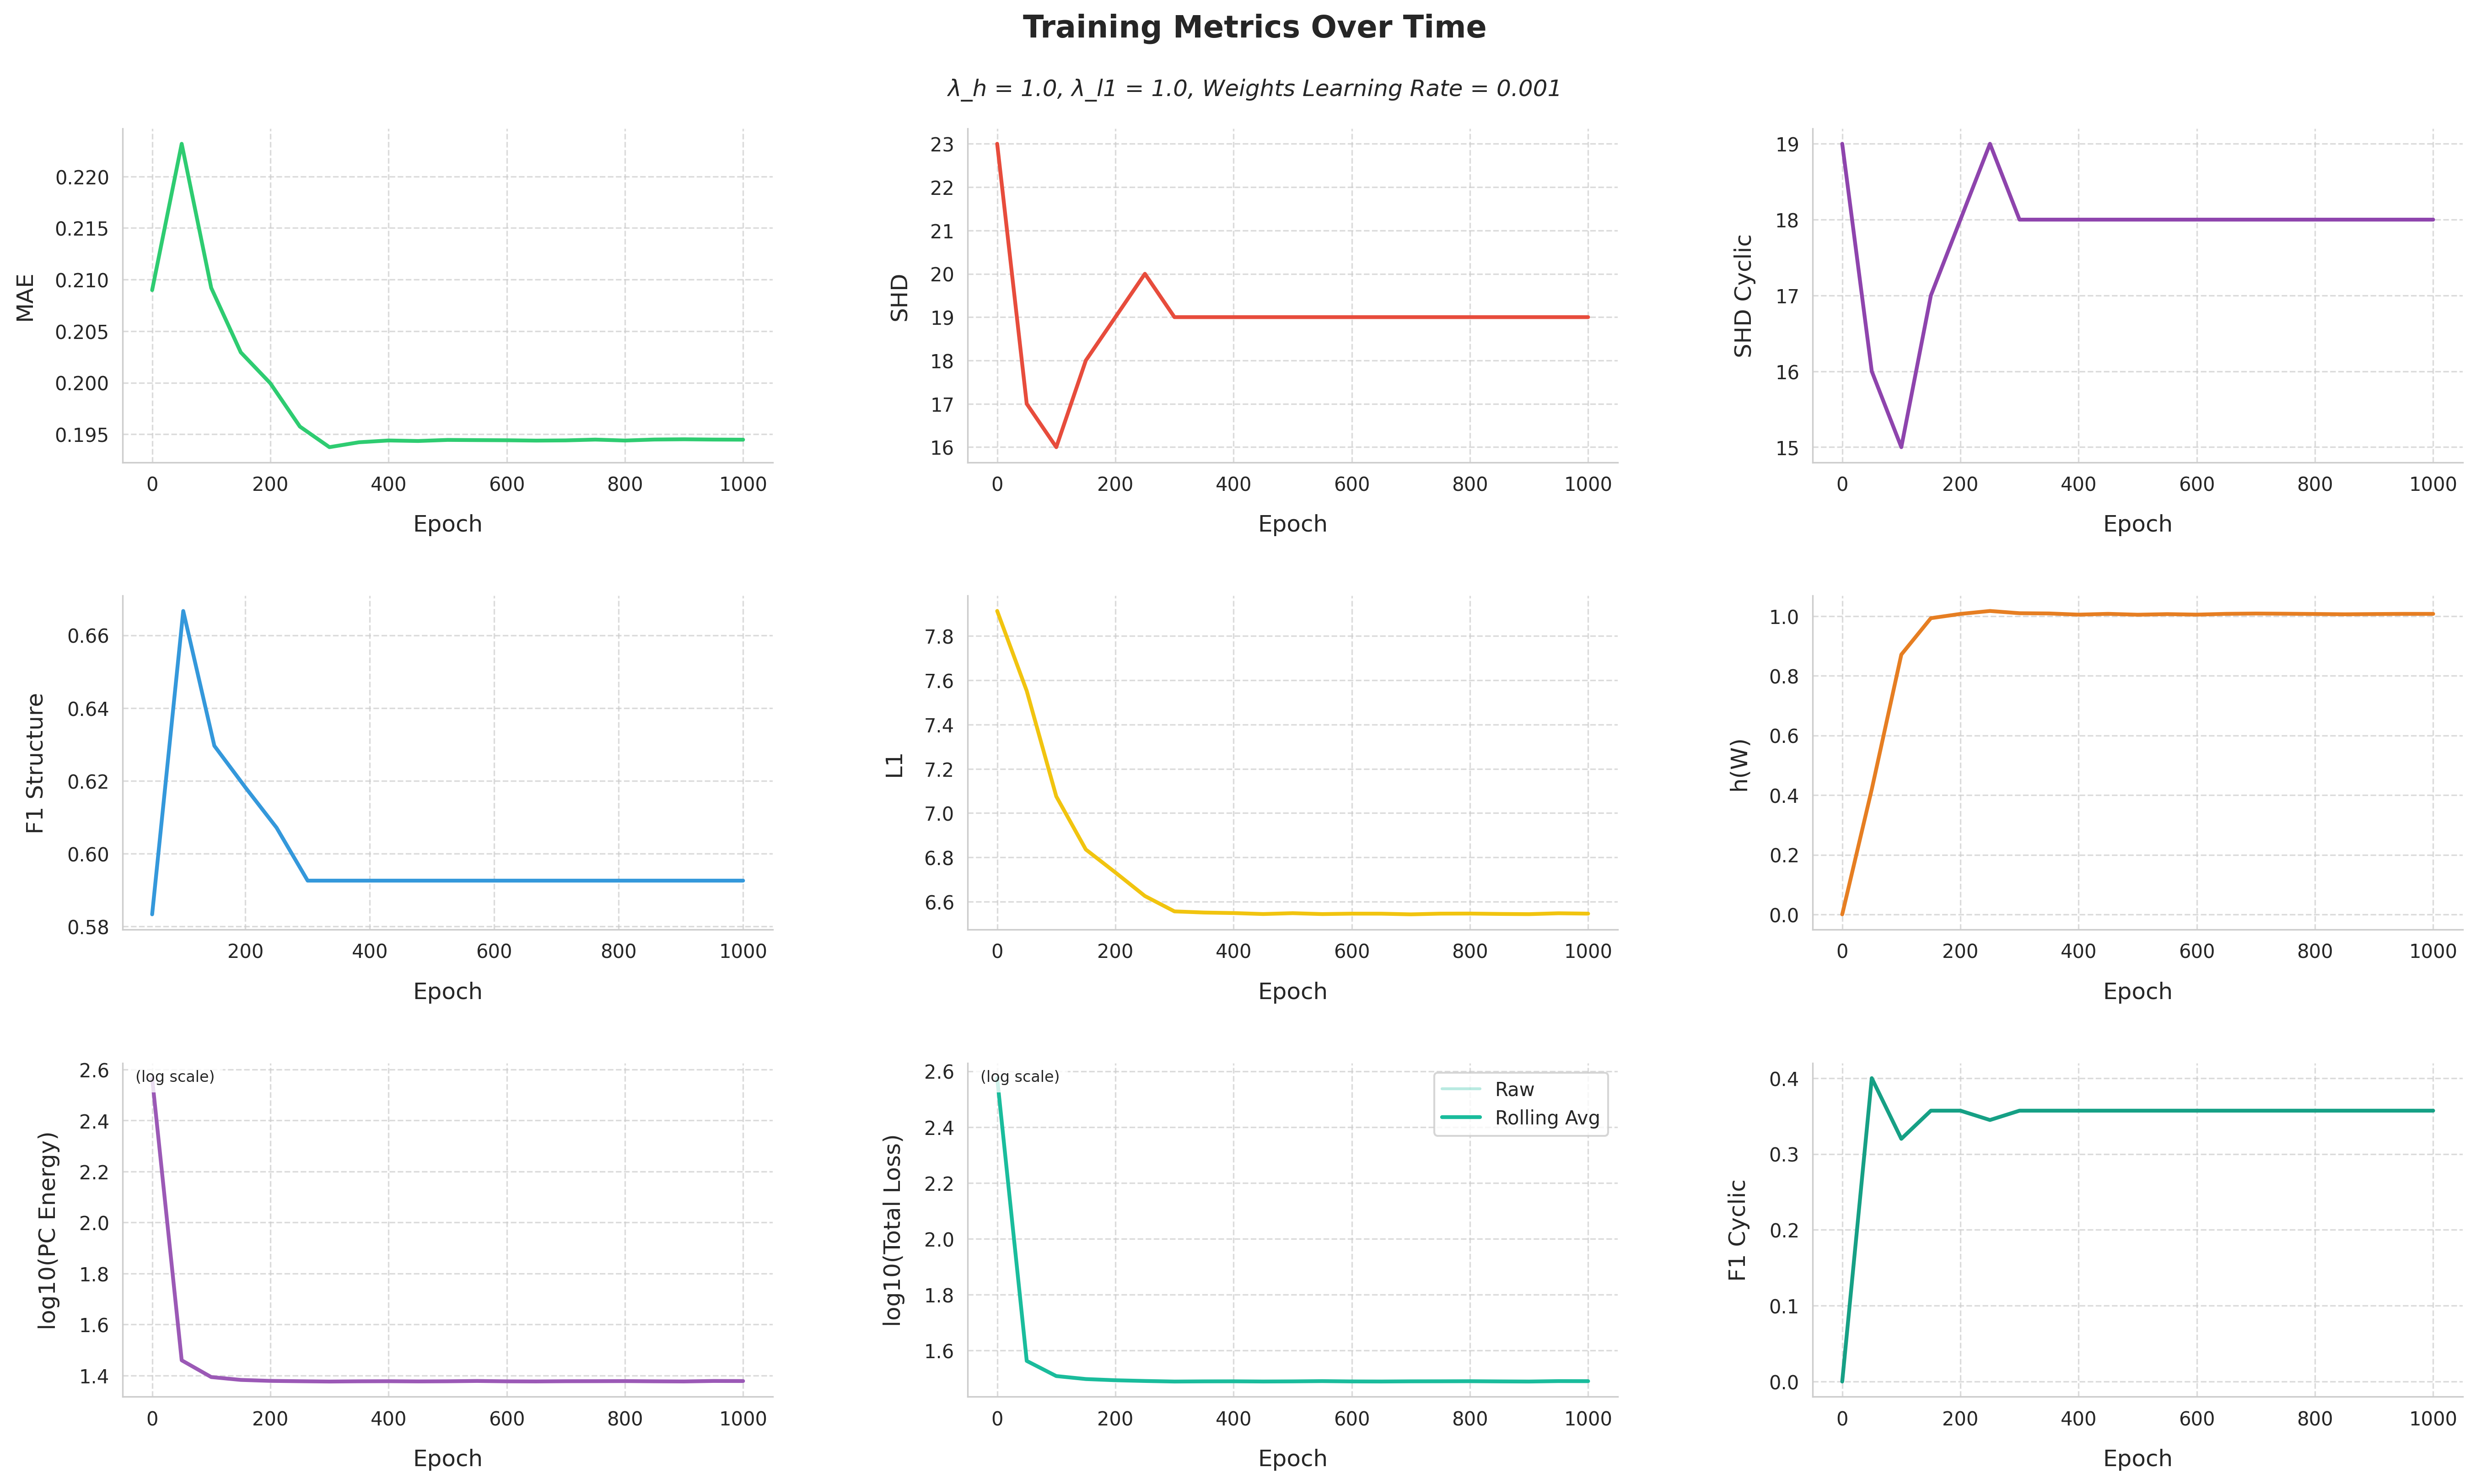

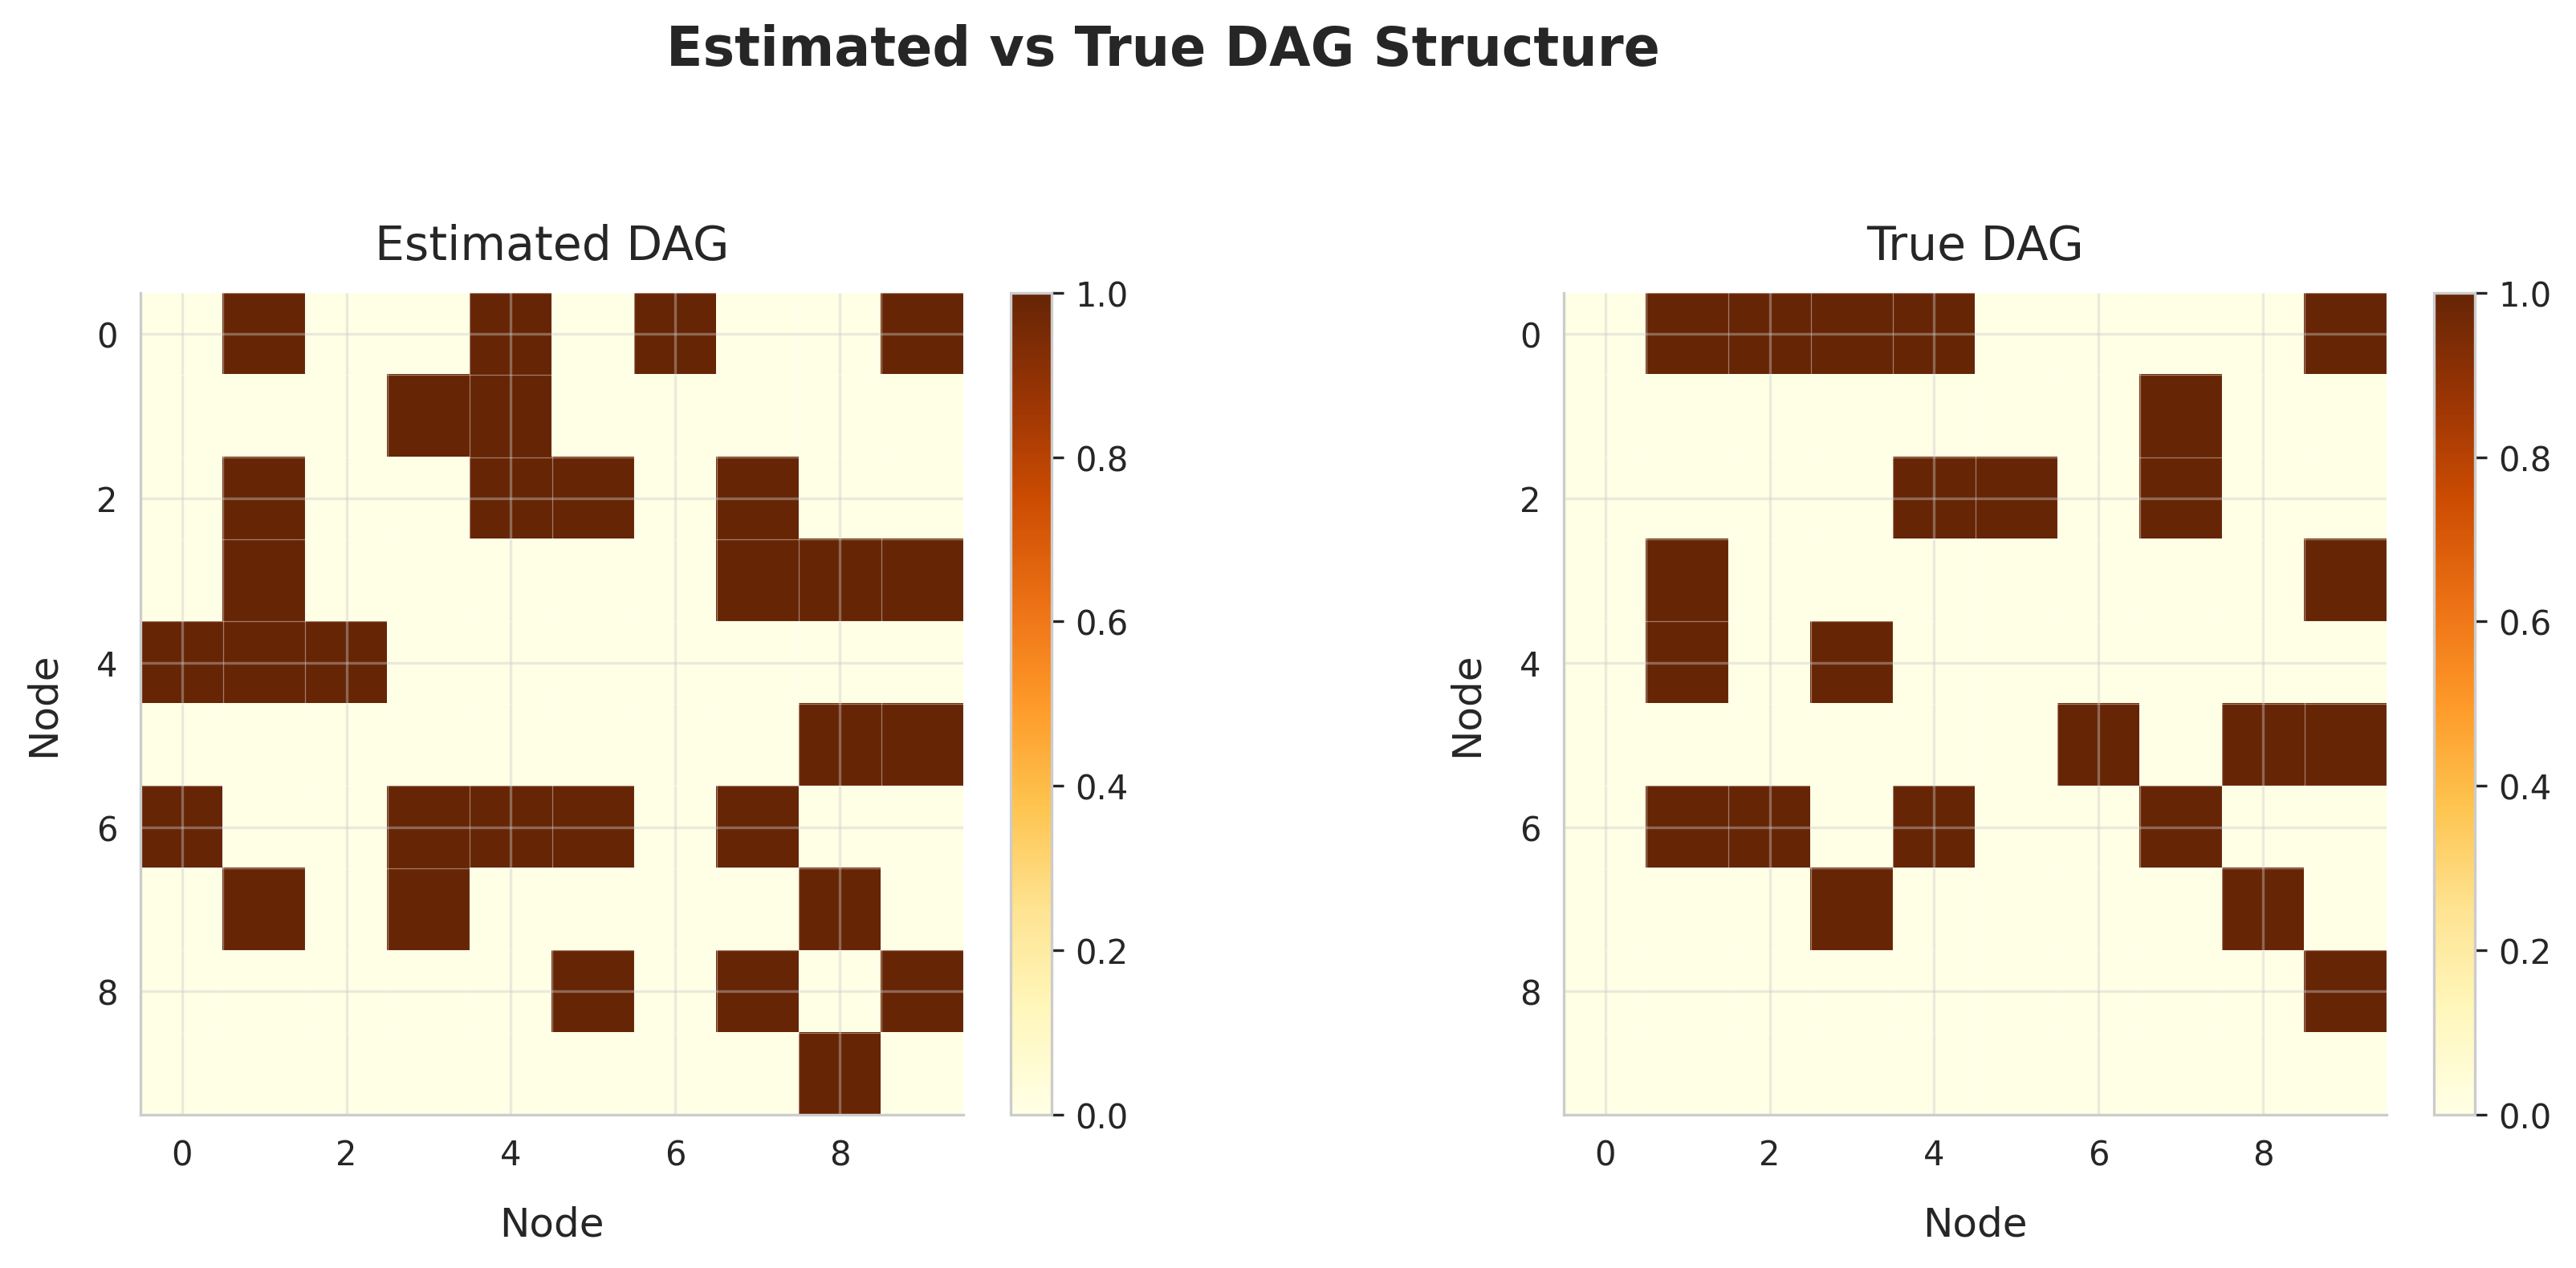

Is the estimated binary adjacency matrix a DAG? False

The h_reg term for the TRUE weighted adjacency matrix W_true is: 0.3104
The h_reg term for the EST weighted adjacency matrix W_est is: 1.0073

The number of edges in the TRUE graph: 23.0
The number of edges in the EST graph: 31

The first 5 rows and columns of the estimated weighted adjacency matrix W_est
[[ 0.     -0.4679  0.0049  0.178   1.0105]
 [-0.1615  0.      0.1553 -0.4386  0.3251]
 [ 0.0019  0.4346  0.      0.0001  0.5513]
 [ 0.0803 -0.5222  0.0006  0.     -0.0019]
 [ 0.4246  0.3382  0.3217  0.0013  0.    ]]


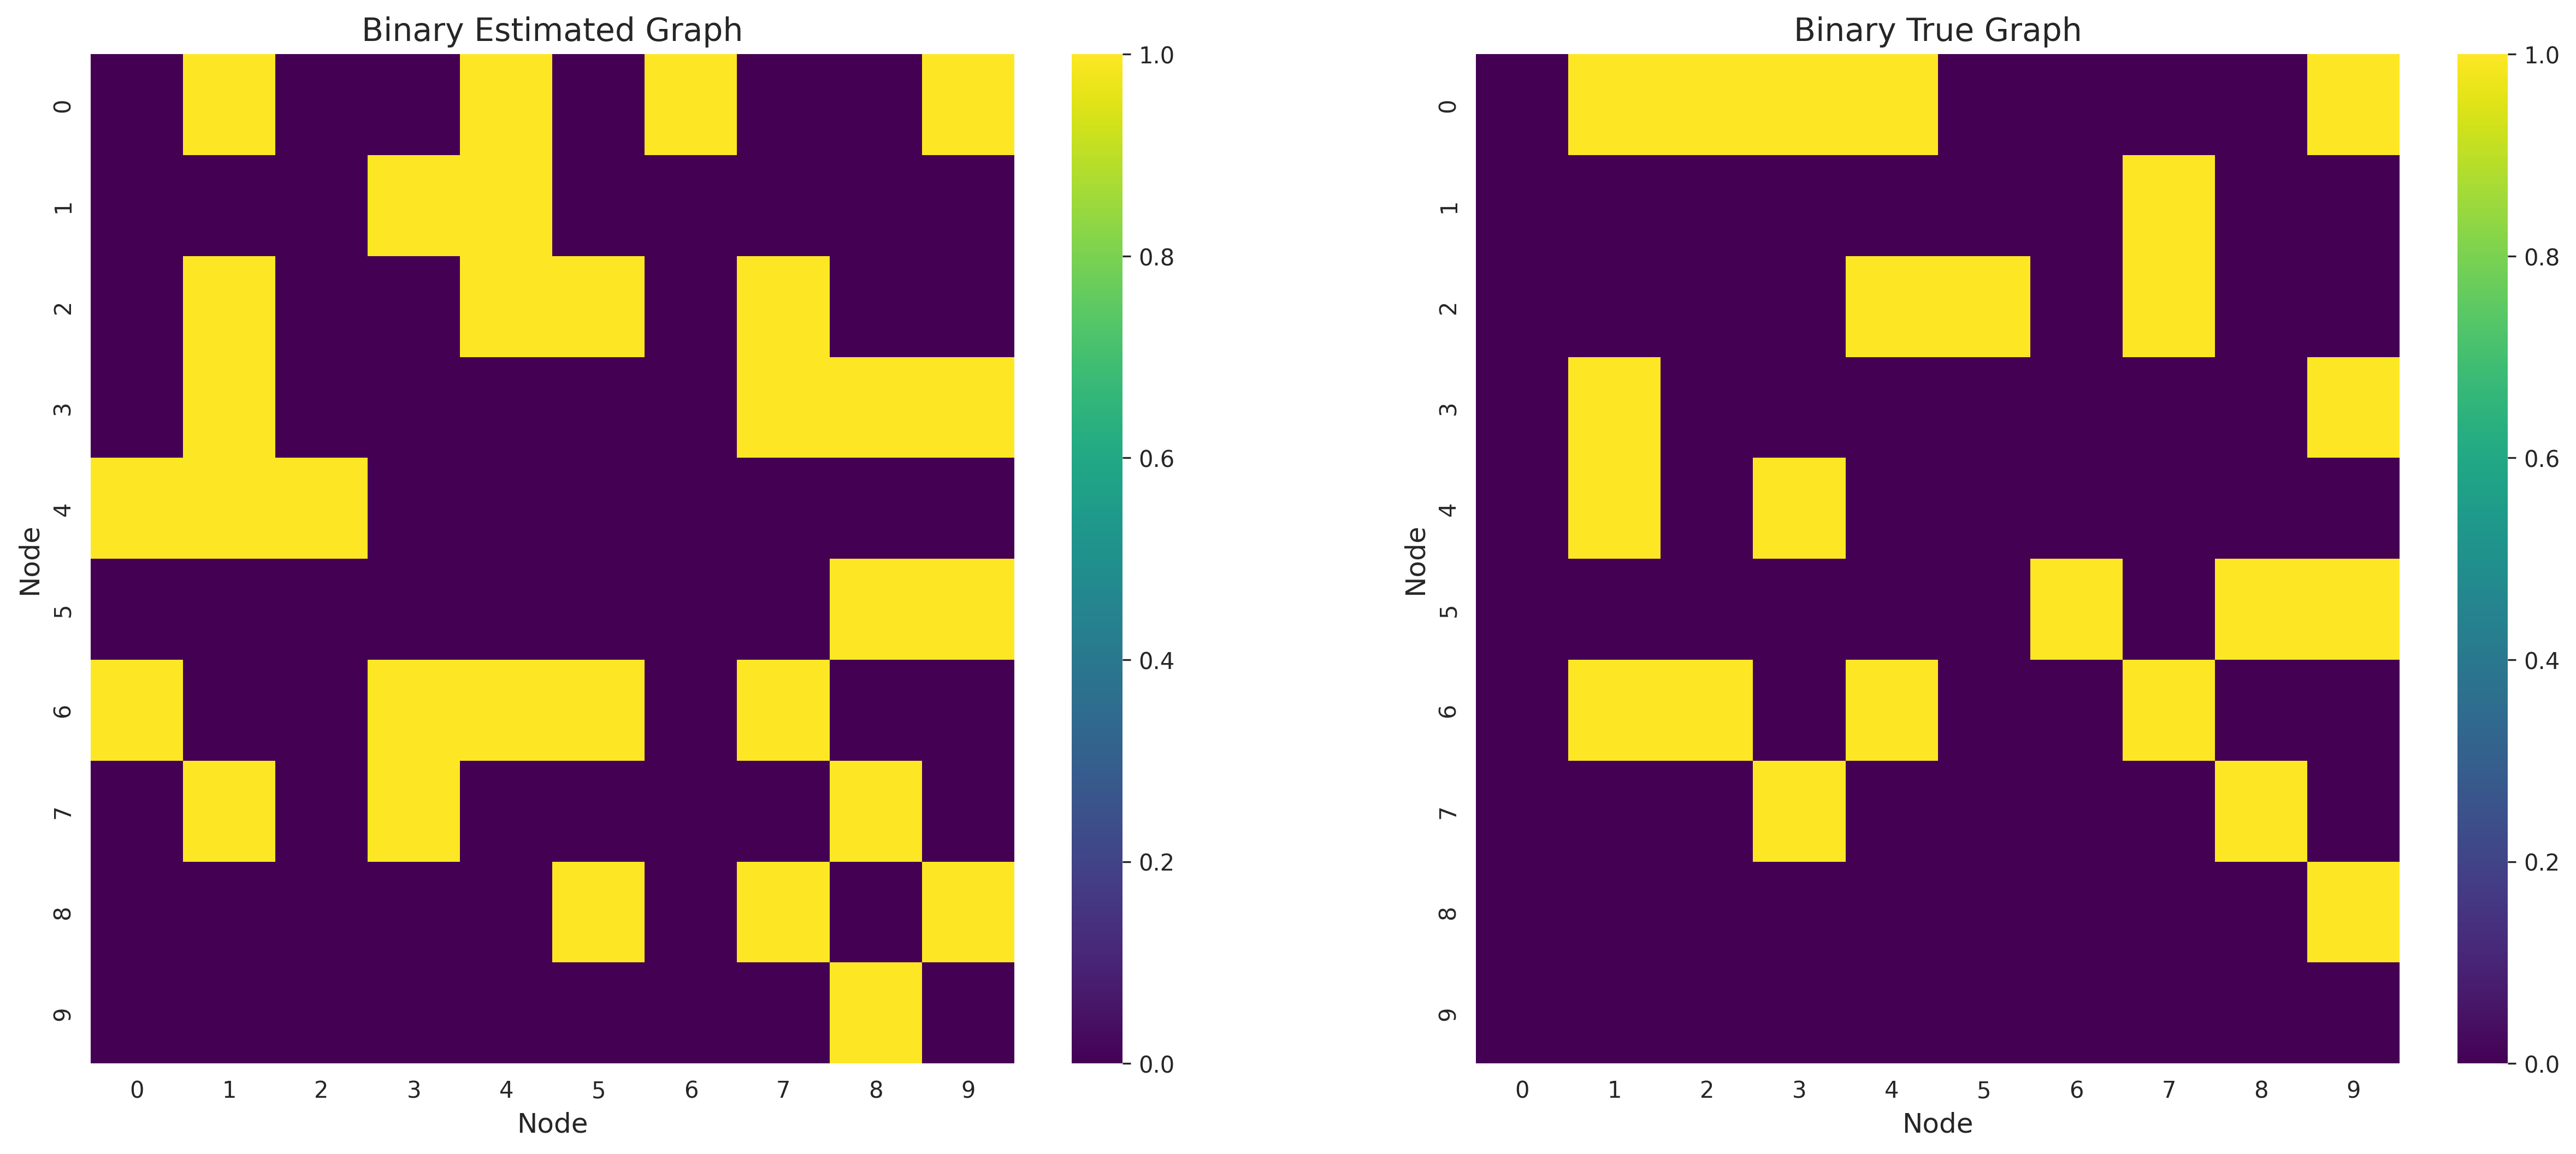

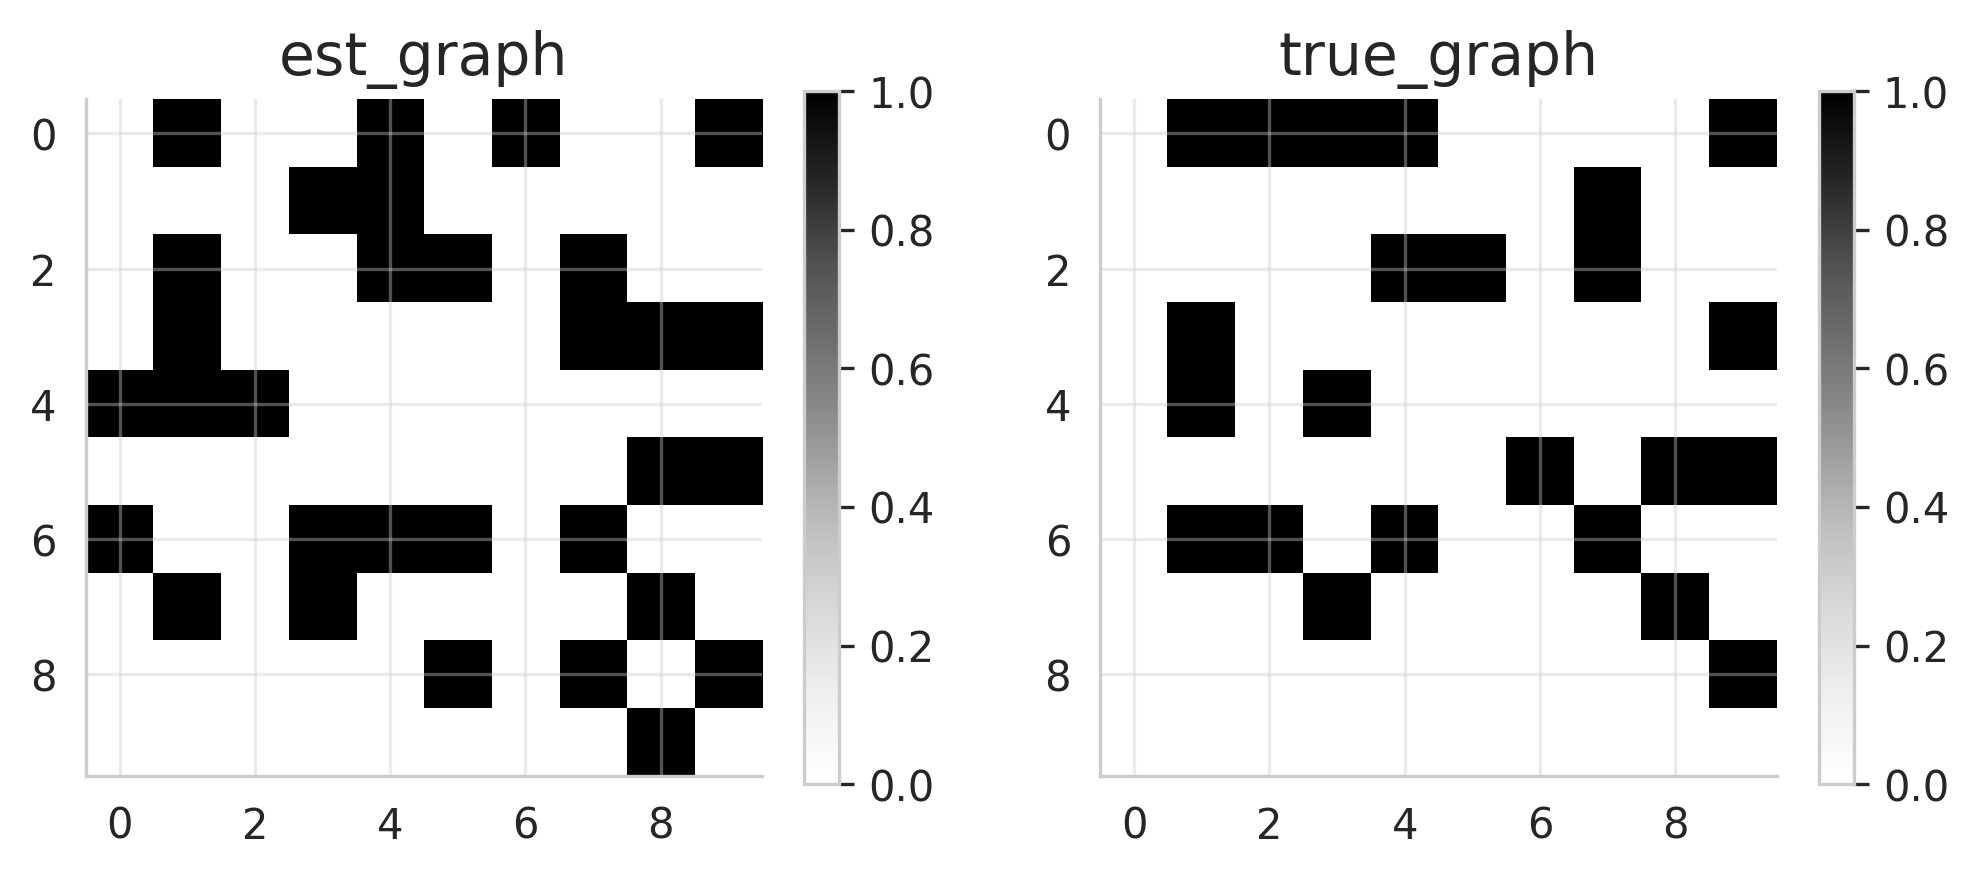

{'fdr': 0.4091, 'tpr': 0.5652, 'fpr': 0.4091, 'shd': 14, 'nnz': 22, 'precision': 0.5909, 'recall': 0.5652, 'F1': 0.5778, 'gscore': 0.1739}


In [12]:
# Define experiment name
exp_name = f"bs_{batch_size}_lrw_{w_learning_rate}_lrh_{h_learning_rate}_lamh_{lam_h}_laml1_{lam_l1}_epochs_{nm_epochs}"

# Create subdirectory in linear folder with the name stored in exp_name
save_path = os.path.join('plots/linear_cyclic', exp_name)
os.makedirs(save_path, exist_ok=True)

# Reset to default style and set seaborn style
plt.style.use('default')
sns.set_style("whitegrid")

# Update matplotlib parameters
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.grid': True,
    'grid.alpha': 0.4,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Create a figure and subplots using GridSpec with 3x3 layout
fig = plt.figure(figsize=(22, 12))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])

# Adjust layout to make room for titles and subtitles
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)

# Create axes
axes = [fig.add_subplot(gs[i, j]) for i in range(3) for j in range(3)]

# Updated plot configurations
plot_configs = [
    {'metric': MAEs, 'title': 'MAE', 'ylabel': 'MAE', 'color': '#2ecc71', 'ax': axes[0]},
    {'metric': SHDs, 'title': 'SHD', 'ylabel': 'SHD', 'color': '#e74c3c', 'ax': axes[1]},
    {'metric': SHDs_cyclic, 'title': 'SHD Cyclic', 'ylabel': 'SHD Cyclic', 'color': '#8e44ad', 'ax': axes[2]},
    {'metric': F1s, 'title': 'F1 Score', 'ylabel': 'F1 Structure', 'color': '#3498db', 'ax': axes[3]},
    {'metric': l1_regs, 'title': 'L1 Regularization', 'ylabel': 'L1', 'color': '#f1c40f', 'ax': axes[4]},
    {'metric': h_regs, 'title': 'DAG Constraint', 'ylabel': 'h(W)', 'color': '#e67e22', 'ax': axes[5]},
    {'metric': pc_energies, 'title': 'PC Energy', 'ylabel': 'PC Energy', 'color': '#9b59b6', 'ax': axes[6]},
    {'metric': objs, 'title': 'Total Objective', 'ylabel': 'Total Loss', 'color': '#1abc9c', 'ax': axes[7]},
    {'metric': F1s_cycles, 'title': 'F1 Cyclic', 'ylabel': 'F1 Cyclic', 'color': '#16a085', 'ax': axes[8]}
]

# Create all subplots
for config in plot_configs:
    ax = config['ax']

    epochs = range(0, len(config['metric']) * every_n_epochs, every_n_epochs)
    
    # Determine if we should use log scale and/or scaling factor
    use_log_scale = config['title'] in ['PC Energy', 'Total Objective']
    #scale_factor = 1e4 if config['title'] == 'DAG Constraint' else 1
    scale_factor = 1 if config['title'] == 'DAG Constraint' else 1
    
    # Apply scaling and/or log transform to the metric
    metric_values = np.array(config['metric'])
    if use_log_scale:
        # Add small constant to avoid log(0)
        metric_values = np.log10(np.abs(metric_values) + 1e-10)
    metric_values = metric_values * scale_factor

    # Plot raw data
    ax.plot(epochs, metric_values, alpha=0.3, color=config['color'], label='Raw')

    # Calculate rolling average
    window_size = max(1, len(metric_values) // 50)  # Dynamic window size based on number of epochs
    if len(metric_values) > window_size:
        rolling_mean = np.convolve(metric_values, np.ones(window_size) / window_size, mode='valid')
        ax.plot(epochs[window_size - 1:], rolling_mean, color=config['color'], linewidth=2, label='Rolling Avg')

    # Customize subplot
    ax.set_xlabel('Epoch', labelpad=10)
    # Adjust ylabel based on transformations
    ylabel = config['ylabel']
    if use_log_scale:
        ylabel = f'log10({ylabel})'
    if scale_factor != 1:
        ylabel = f'{ylabel} (×{int(scale_factor)})'
    ax.set_ylabel(ylabel, labelpad=10)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add legend for Total Objective plot
    if config['title'] == 'Total Objective':
        ax.legend(loc='upper right')

    # Add note about scaling if applicable
    if use_log_scale or scale_factor != 1:
        transform_text = []
        if use_log_scale:
            transform_text.append('log scale')
        if scale_factor != 1:
            transform_text.append(f'×{int(scale_factor)}')
        ax.text(0.02, 0.98, f"({', '.join(transform_text)})", 
                transform=ax.transAxes, 
                fontsize=8, 
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))        

# Add overall title and subtitle with adjusted positions
fig.suptitle('Training Metrics Over Time', 
             fontsize=16, 
             weight='bold', 
             y=0.95)  # Lower the main title slightly

subtitle = f'λ_h = {lam_h}, λ_l1 = {lam_l1}, Weights Learning Rate = {w_learning_rate}'
fig.text(0.5, 0.90,  # Adjusted y position for the subtitle
         subtitle, 
         horizontalalignment='center',
         fontsize=12,
         style='italic')

# Adjust layout to make more room for title and subtitle
plt.subplots_adjust(top=0.88, hspace=0.4, wspace=0.3)


# Save and show the figure as a .pdf file
plt.savefig(os.path.join(save_path, 'training_metrics.pdf'), bbox_inches='tight', dpi=300)
plt.show()

########################## Plotting the DAG comparison  ##########################

# Create a separate figure for the adjacency matrices comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Use a better colormap - options:
# 'YlOrBr' - Yellow-Orange-Brown (good for sparse matrices)
# 'viridis' - Perceptually uniform, colorblind-friendly
# 'Greys' - Black and white, professional
# 'YlGnBu' - Yellow-Green-Blue, professional
cmap = 'YlOrBr'  # Choose one of the above

# Plot estimated adjacency matrix (now on the left)
im1 = ax1.imshow(compute_binary_adjacency(W), cmap=cmap, interpolation='nearest')
ax1.set_title('Estimated DAG', pad=10)
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlabel('Node', labelpad=10)
ax1.set_ylabel('Node', labelpad=10)

# Plot true adjacency matrix (now on the right)
im2 = ax2.imshow(B_true, cmap=cmap, interpolation='nearest')
ax2.set_title('True DAG', pad=10)
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_xlabel('Node', labelpad=10)
ax2.set_ylabel('Node', labelpad=10)

# Add overall title
fig.suptitle('Estimated vs True DAG Structure', 
             fontsize=16, 
             weight='bold', 
             y=1.05)

# Add grid lines to better separate the nodes
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(-.5, B_true.shape[0], 1), minor=True)
    ax.set_yticks(np.arange(-.5, B_true.shape[0], 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)

# Improve layout
plt.tight_layout()

# Save the comparison plot as a .pdf file at the specified location
plt.savefig(os.path.join(save_path, 'dag_comparison.pdf'), 
            bbox_inches='tight', 
            dpi=300,
            facecolor='white',
            edgecolor='none')
plt.show()

# %%
# Now use a threshold of 0.3 to binarize the weighted adjacency matrix W
W_est = np.array(model.get_W())
B_est = compute_binary_adjacency(W_est, threshold=0.3)

# %%
# Check if B_est is indeed a DAG
def is_dag(adjacency_matrix):
    """
    Check if a given adjacency matrix represents a Directed Acyclic Graph (DAG).
    
    Parameters:
        adjacency_matrix (numpy.ndarray): A square matrix representing the adjacency of a directed graph.
        
    Returns:
        bool: True if the graph is a DAG, False otherwise.
    """
    # Create a directed graph from the adjacency matrix
    graph = nx.DiGraph(adjacency_matrix)
    
    # Check if the graph is a DAG
    return nx.is_directed_acyclic_graph(graph)

# Check if the estimated binary adjacency matrix B_est is a DAG
is_dag_B_est = is_dag(B_est)
print(f"Is the estimated binary adjacency matrix a DAG? {is_dag_B_est}")

print()

# Compute the h_reg term for the true weighted adjacency matrix W_true
h_reg_true = compute_h_reg(W_true)
print(f"The h_reg term for the TRUE weighted adjacency matrix W_true is: {h_reg_true:.4f}")
# Compute the h_reg term for the estimated weighted adjacency matrix W_est
h_reg_est = compute_h_reg(W_est)
print(f"The h_reg term for the EST weighted adjacency matrix W_est is: {h_reg_est:.4f}")

print()

# print the number of edges in the true graph and the estimated graph
print(f"The number of edges in the TRUE graph: {np.sum(B_true)}")
print(f"The number of edges in the EST graph: {np.sum(B_est)}")

# print first 5 rows and columsn of W_est and round values to 4 decimal places and show as non-scientific notation
np.set_printoptions(precision=4, suppress=True)

print()

print("The first 5 rows and columns of the estimated weighted adjacency matrix W_est\n{}".format(W_est[:5, :5]))

# now show the adjacency matrix of the true graph and the estimated graph side by side
plot_adjacency_matrices(true_matrix=B_true, est_matrix=B_est, save_path=os.path.join(save_path, 'adjacency_matrices.png'))


# %%
# plot est_dag and true_dag
GraphDAG(B_est, B_true, save_name=os.path.join(save_path, 'est_dag_true_dag.png'))
# calculate accuracy
met_pcx = MetricsDAG(B_est, B_true) # expects first arg to be the predicted labels and the second arg to be the true labels
print(met_pcx.metrics)

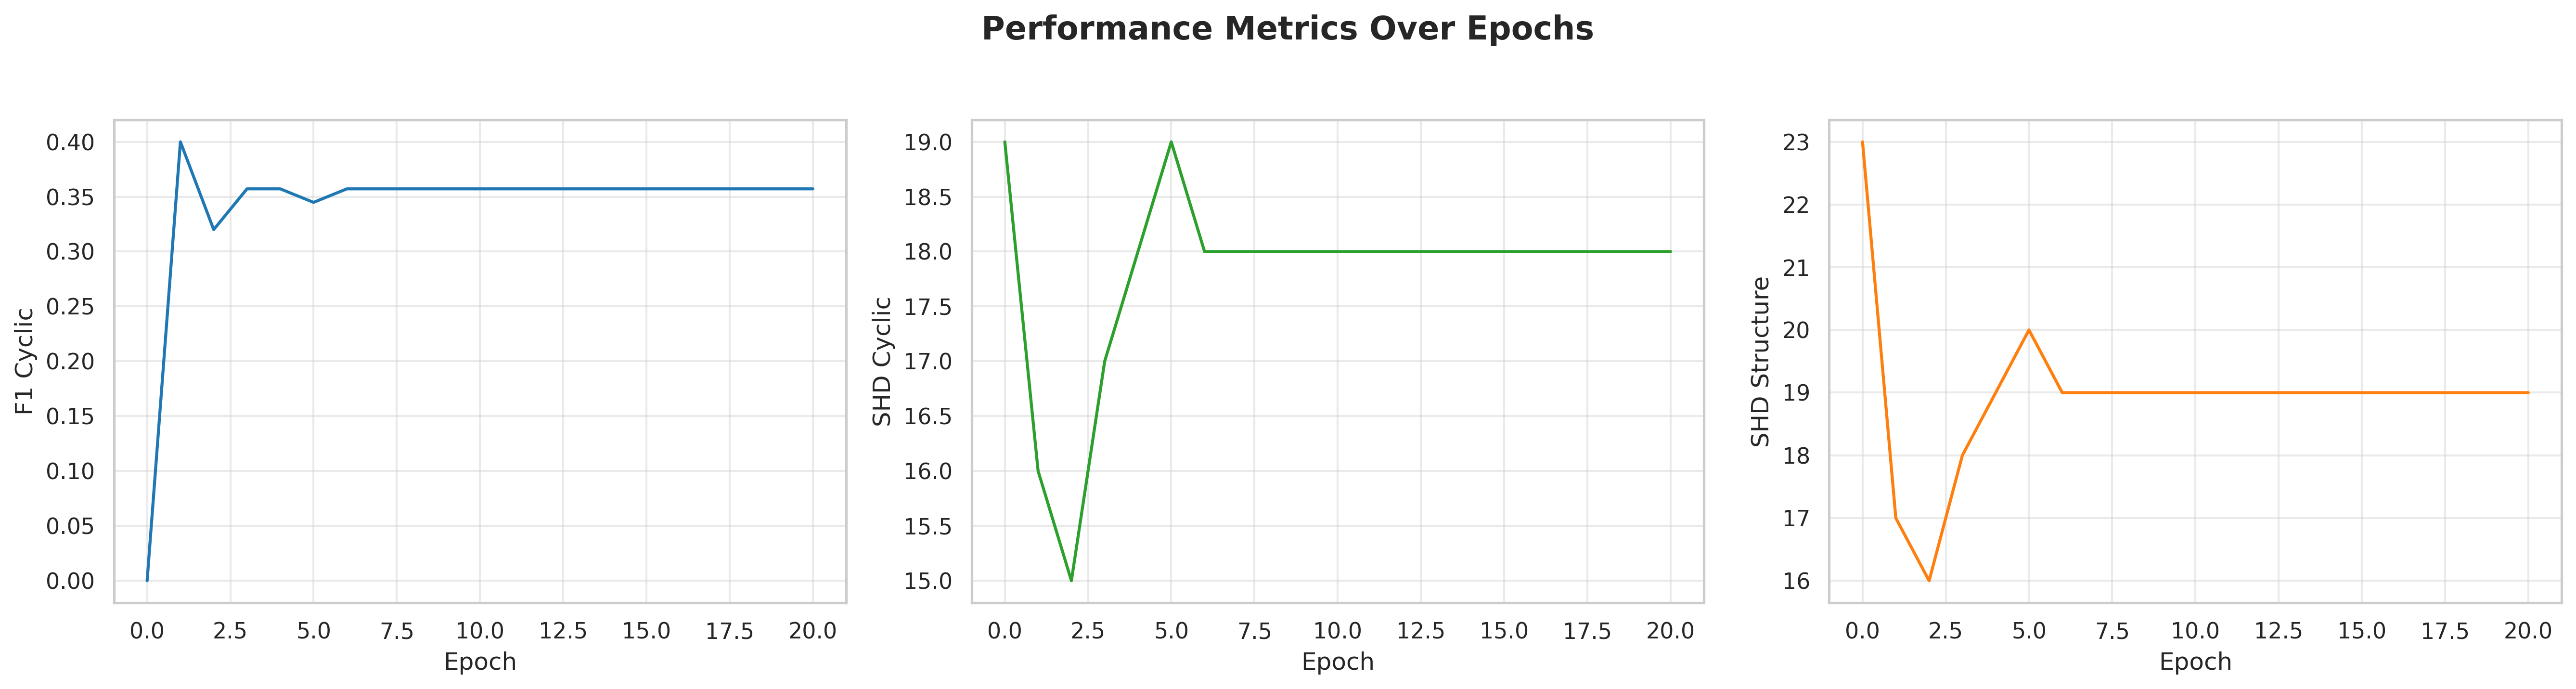

In [13]:
# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("tab10")

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjusting layout to 1 row and 3 columns
fig.suptitle('Performance Metrics Over Epochs', fontsize=16, weight='bold')

# Plot the Cyclic F1 score
sns.lineplot(x=range(len(F1s_cycles)), y=F1s_cycles, ax=axs[0], color=palette[0])
axs[0].set_xlabel("Epoch", fontsize=12)
axs[0].set_ylabel("F1 Cyclic", fontsize=12)
axs[0].grid(True)

# Plot the Cyclic SHD
sns.lineplot(x=range(len(SHDs)), y=SHDs_cyclic, ax=axs[1], color=palette[2])
axs[1].set_xlabel("Epoch", fontsize=12)
axs[1].set_ylabel("SHD Cyclic", fontsize=12)
axs[1].grid(True)

# Plot the vanilla SHD
sns.lineplot(x=range(len(SHDs)), y=SHDs, ax=axs[2], color=palette[1])
axs[2].set_xlabel("Epoch", fontsize=12)
axs[2].set_ylabel("SHD Structure", fontsize=12)
axs[2].grid(True)

# Improve layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

In [14]:
# print first 5 rows and columsn of W_est and round values to 4 decimal places and show as non-scientific notation
np.set_printoptions(precision=4, suppress=True)

print("The first 4 rows and columns of the estimated weighted adjacency matrix W_est\n{}".format(W_est[:11, :11]))

The first 4 rows and columns of the estimated weighted adjacency matrix W_est
[[ 0.     -0.4679  0.0049  0.178   1.0105  0.0781 -0.4845  0.1973 -0.2873
   0.7011]
 [-0.1615  0.      0.1553 -0.4386  0.3251  0.0008 -0.0455  0.2897 -0.001
   0.0002]
 [ 0.0019  0.4346  0.      0.0001  0.5513  0.3223 -0.0006 -0.3202 -0.0023
   0.0022]
 [ 0.0803 -0.5222  0.0006  0.     -0.0019 -0.1042 -0.1827 -0.3237  0.3076
  -0.7101]
 [ 0.4246  0.3382  0.3217  0.0013  0.      0.0191  0.2724 -0.1404 -0.0039
  -0.0001]
 [ 0.025   0.0003  0.2465 -0.1192  0.0005  0.     -0.2328  0.2665  0.7345
  -0.7552]
 [-0.5487 -0.1623 -0.0523 -0.4123  0.7786 -0.3178  0.     -0.3485  0.
  -0.0004]
 [ 0.1139  0.4837 -0.2021 -0.38   -0.1906  0.2694 -0.2062  0.     -0.5265
   0.0003]
 [-0.0597  0.0003  0.0023  0.2245  0.0005  0.4483  0.0008 -0.3836  0.
   1.0061]
 [ 0.0868  0.0002  0.0053 -0.2539  0.003  -0.1893 -0.     -0.0006  0.4591
   0.    ]]


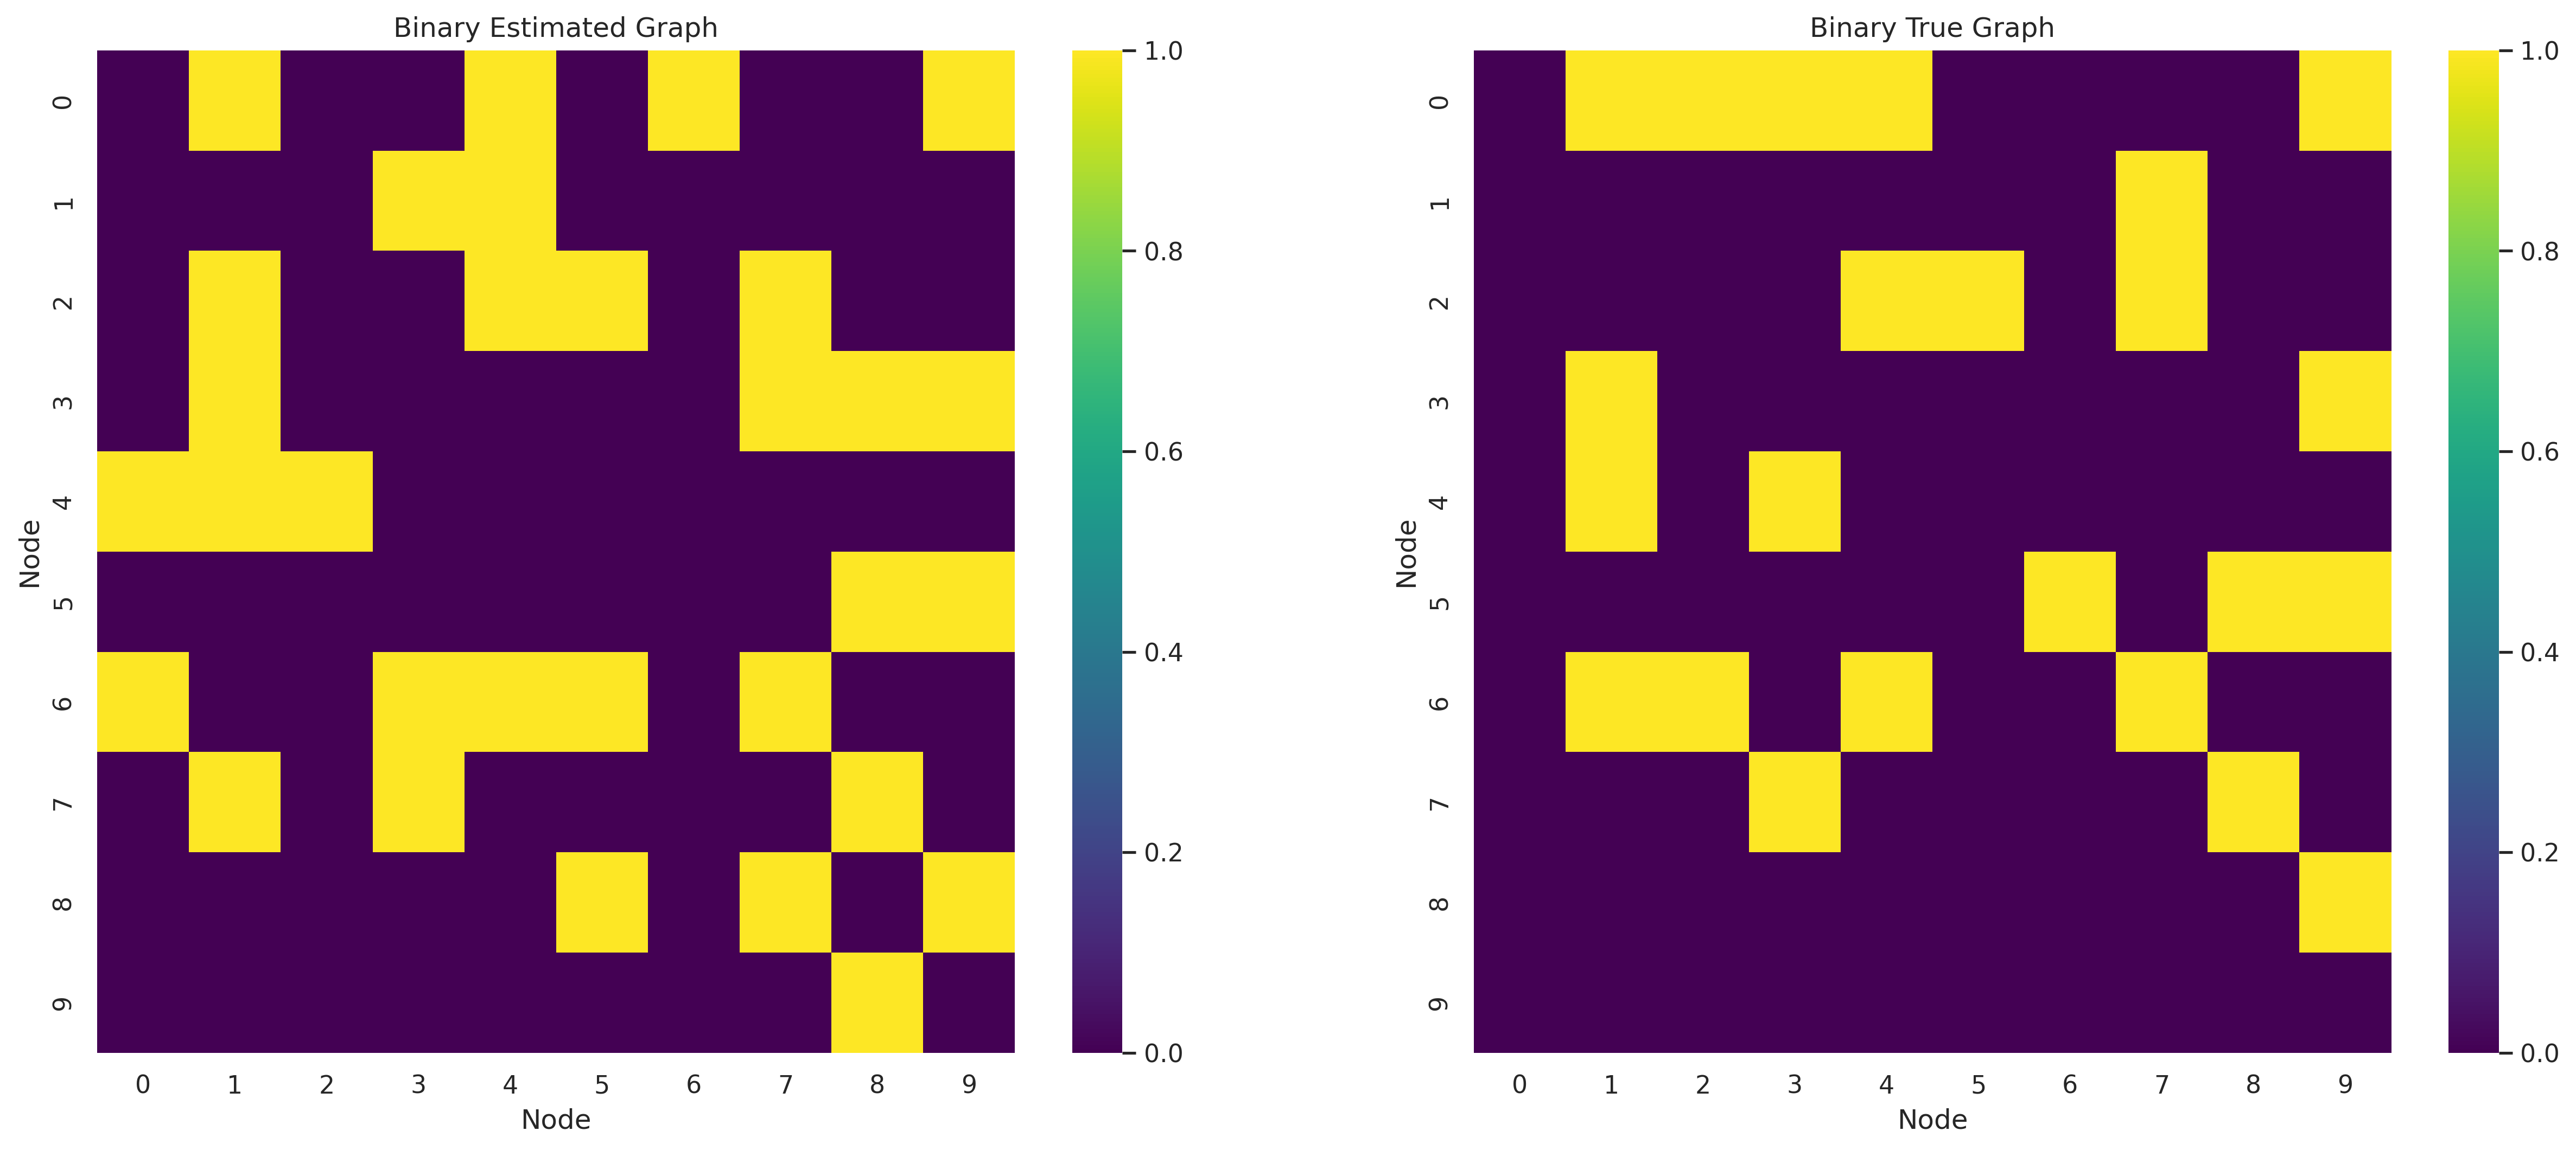

The number of edges in the estimated graph: 31
The number of edges in the true graph: 23.0


In [15]:
# now show the adjacency matrix of the true graph and the estimated graph side by side
plot_adjacency_matrices(B_true, B_est)

# print the number of edges in the true graph and the estimated graph
print(f"The number of edges in the estimated graph: {np.sum(B_est)}")
print(f"The number of edges in the true graph: {np.sum(B_true)}")

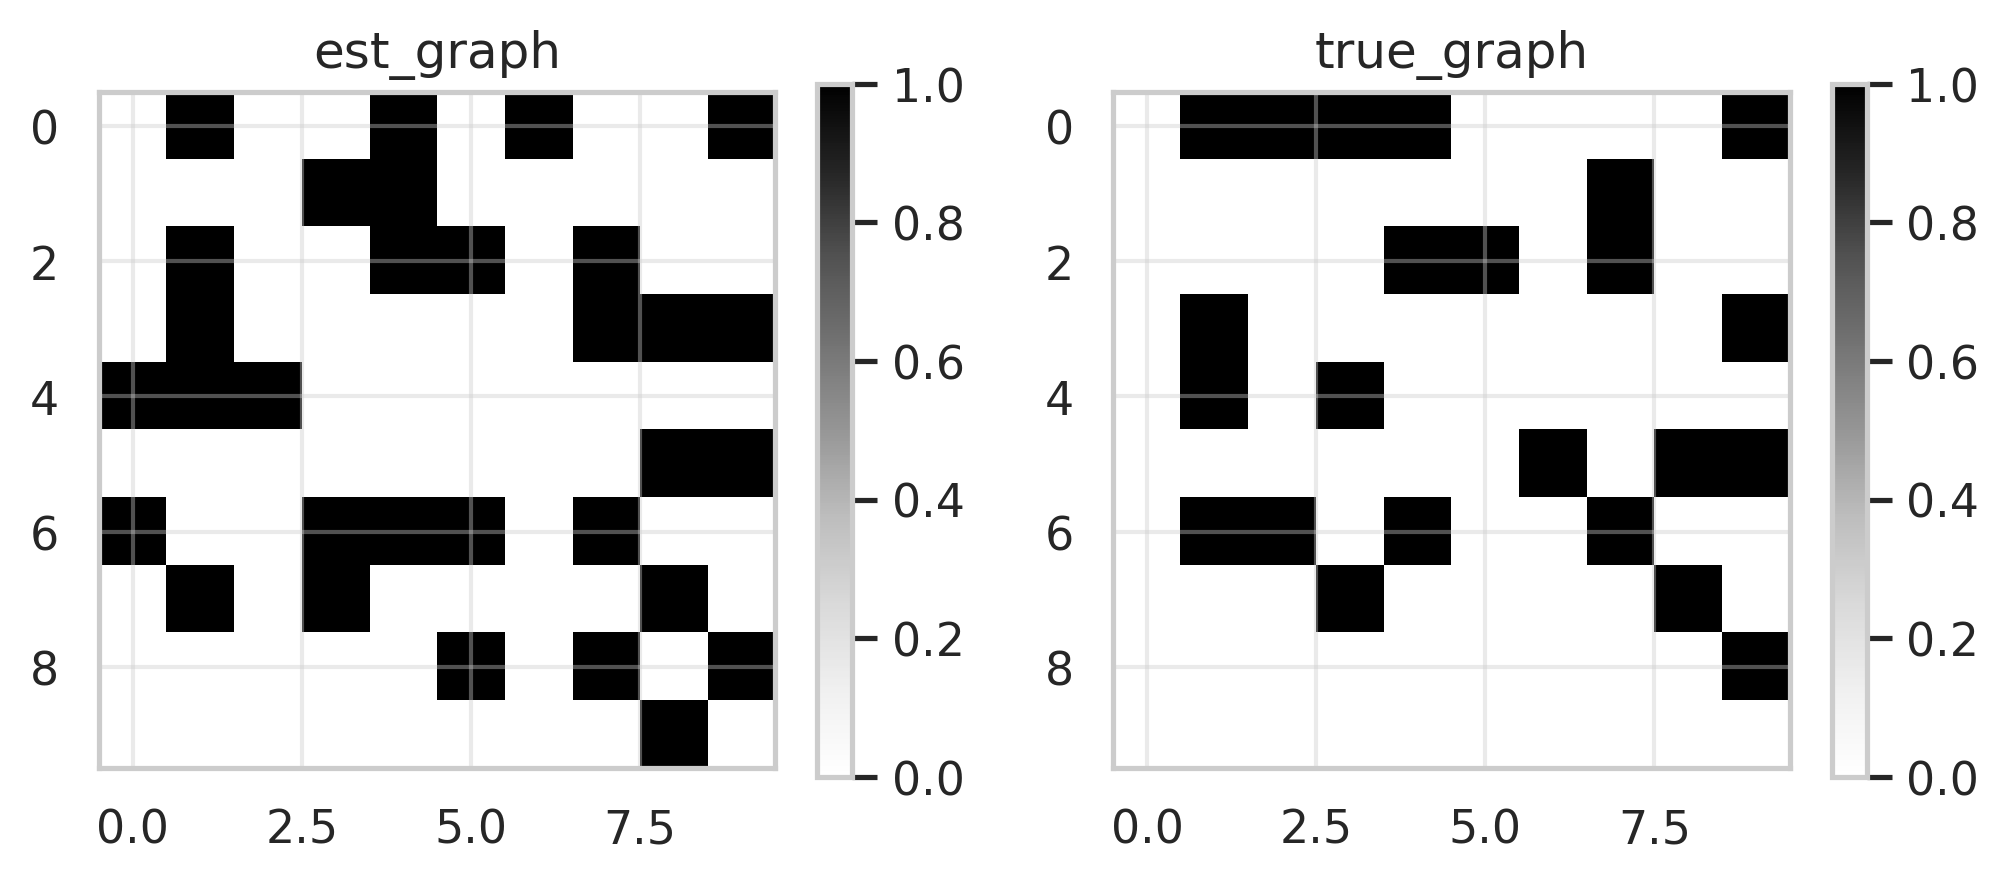

{'fdr': 0.4091, 'tpr': 0.5652, 'fpr': 0.4091, 'shd': 14, 'nnz': 22, 'precision': 0.5909, 'recall': 0.5652, 'F1': 0.5778, 'gscore': 0.1739}
bs_256_lrw_0.001_lrh_0.0001_lamh_1.0_laml1_1.0_epochs_1000


In [16]:
# plot est_dag and true_dag
GraphDAG(B_est, B_true)
# calculate accuracy
met_pcax = MetricsDAG(B_est, B_true)
print(met_pcax.metrics)

# print experiment name
print(exp_name)

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


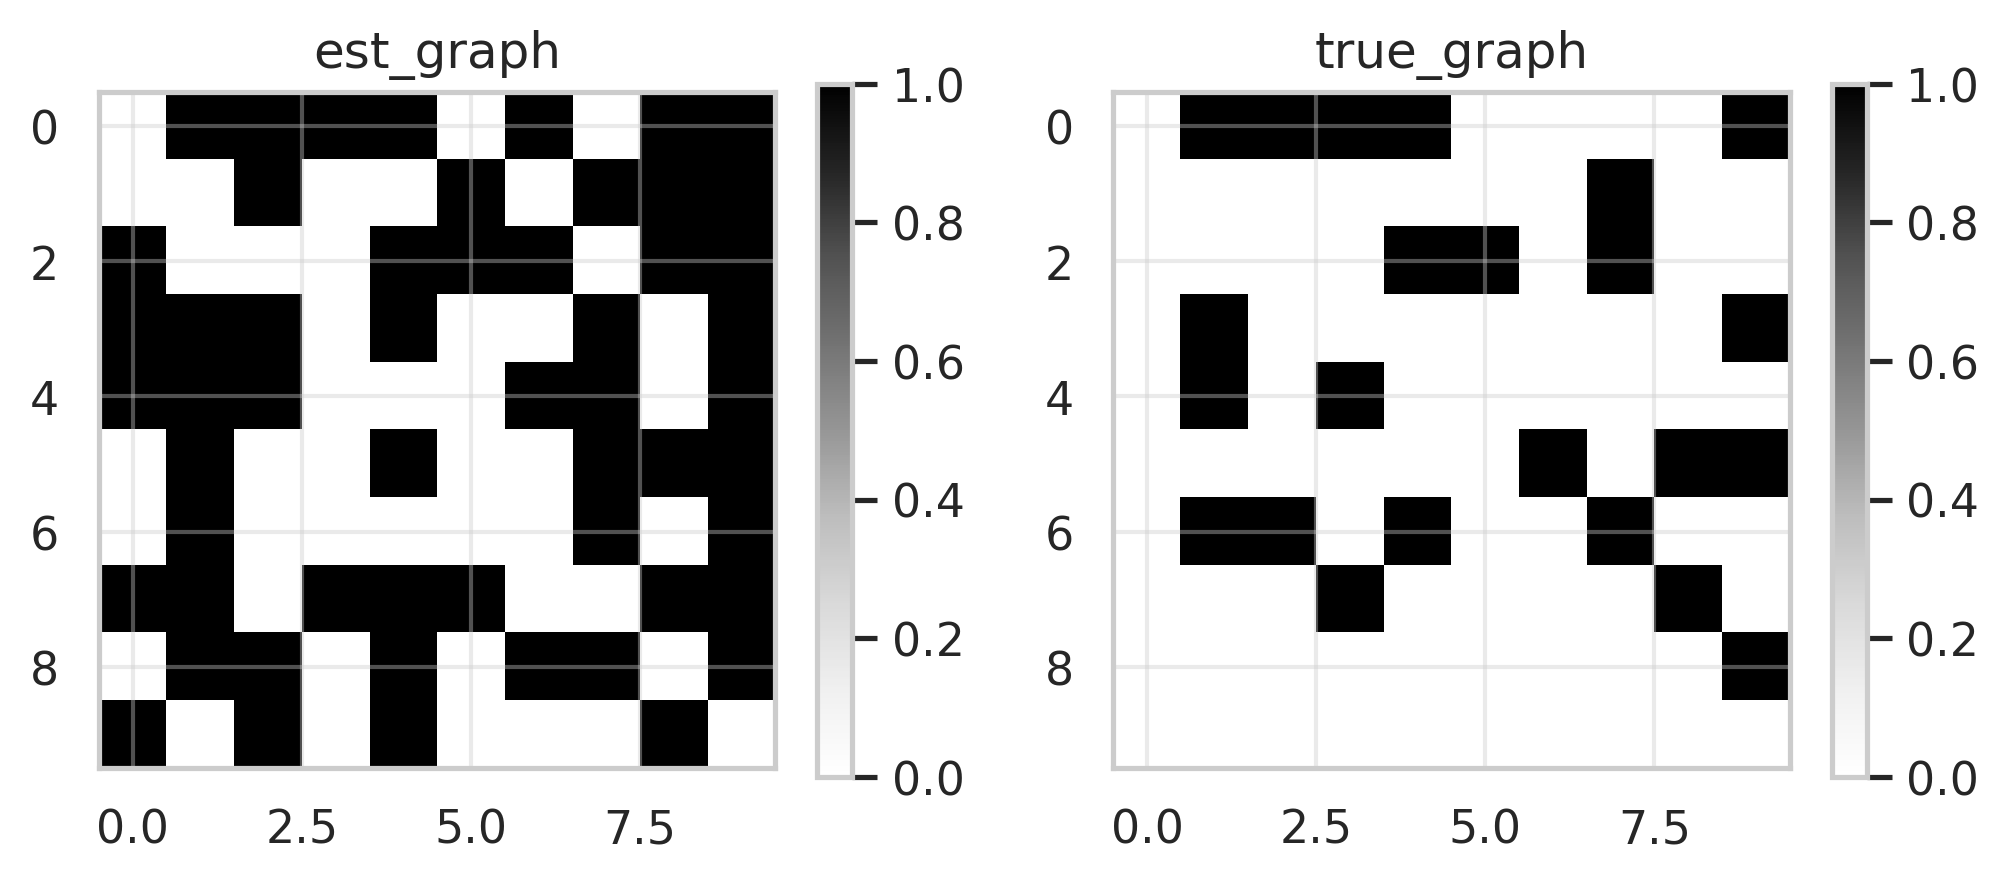

{'fdr': 0.5641, 'tpr': 0.7391, 'fpr': 1.0, 'shd': 24, 'nnz': 39, 'precision': 0.4359, 'recall': 0.7391, 'F1': 0.5484, 'gscore': 0.0}


In [17]:
from lingd import LiNGD

# benchmark model 1 LiNG
ling = LiNGD(k=1)
ling.fit(X)
W_ling = ling._adjacency_matrices[0].T # 0 because we are using k=1, Transpose to make each row correspond to parents
ling_B_est = compute_binary_adjacency(W_ling)

# plot est_dag and true_dag
GraphDAG(ling_B_est, B_true)
# calculate accuracy
met_ling = MetricsDAG(ling_B_est, B_true)
print(met_ling.metrics)

Add edge: 3 -> 1, Delta Score: 1.429e+00 best score: 1.428672315213418
Add edge: 7 -> 8, Delta Score: 1.191e+00 best score: 2.619827791271714
Add edge: 3 -> 7, Delta Score: 1.069e+00 best score: 3.6892492352672797
Add edge: 4 -> 2, Delta Score: 4.538e-01 best score: 4.1430899970376345
Add edge: 8 -> 9, Delta Score: 3.727e-01 best score: 4.515804699804513
Add edge: 6 -> 7, Delta Score: 3.127e-01 best score: 4.828480111879971
Add edge: 3 -> 9, Delta Score: 2.411e-01 best score: 5.0695409797964786
Add edge: 5 -> 8, Delta Score: 2.340e-01 best score: 5.30357013686092
Add edge: 2 -> 7, Delta Score: 1.368e-01 best score: 5.440396053162211
Add edge: 4 -> 0, Delta Score: 1.293e-01 best score: 5.569709231187456
*Refine with greedy steps*
Add edge: 6 -> 0, Delta Score: 2.348e-01
Add edge: 1 -> 0, Delta Score: 2.530e-01
Add edge: 2 -> 5, Delta Score: 1.048e-01
Add edge: 6 -> 5, Delta Score: 1.467e-01
Add edge: 0 -> 4, Delta Score: 9.198e-02
Add edge: 1 -> 7, Delta Score: 8.929e-02
Add edge: 2 -> 

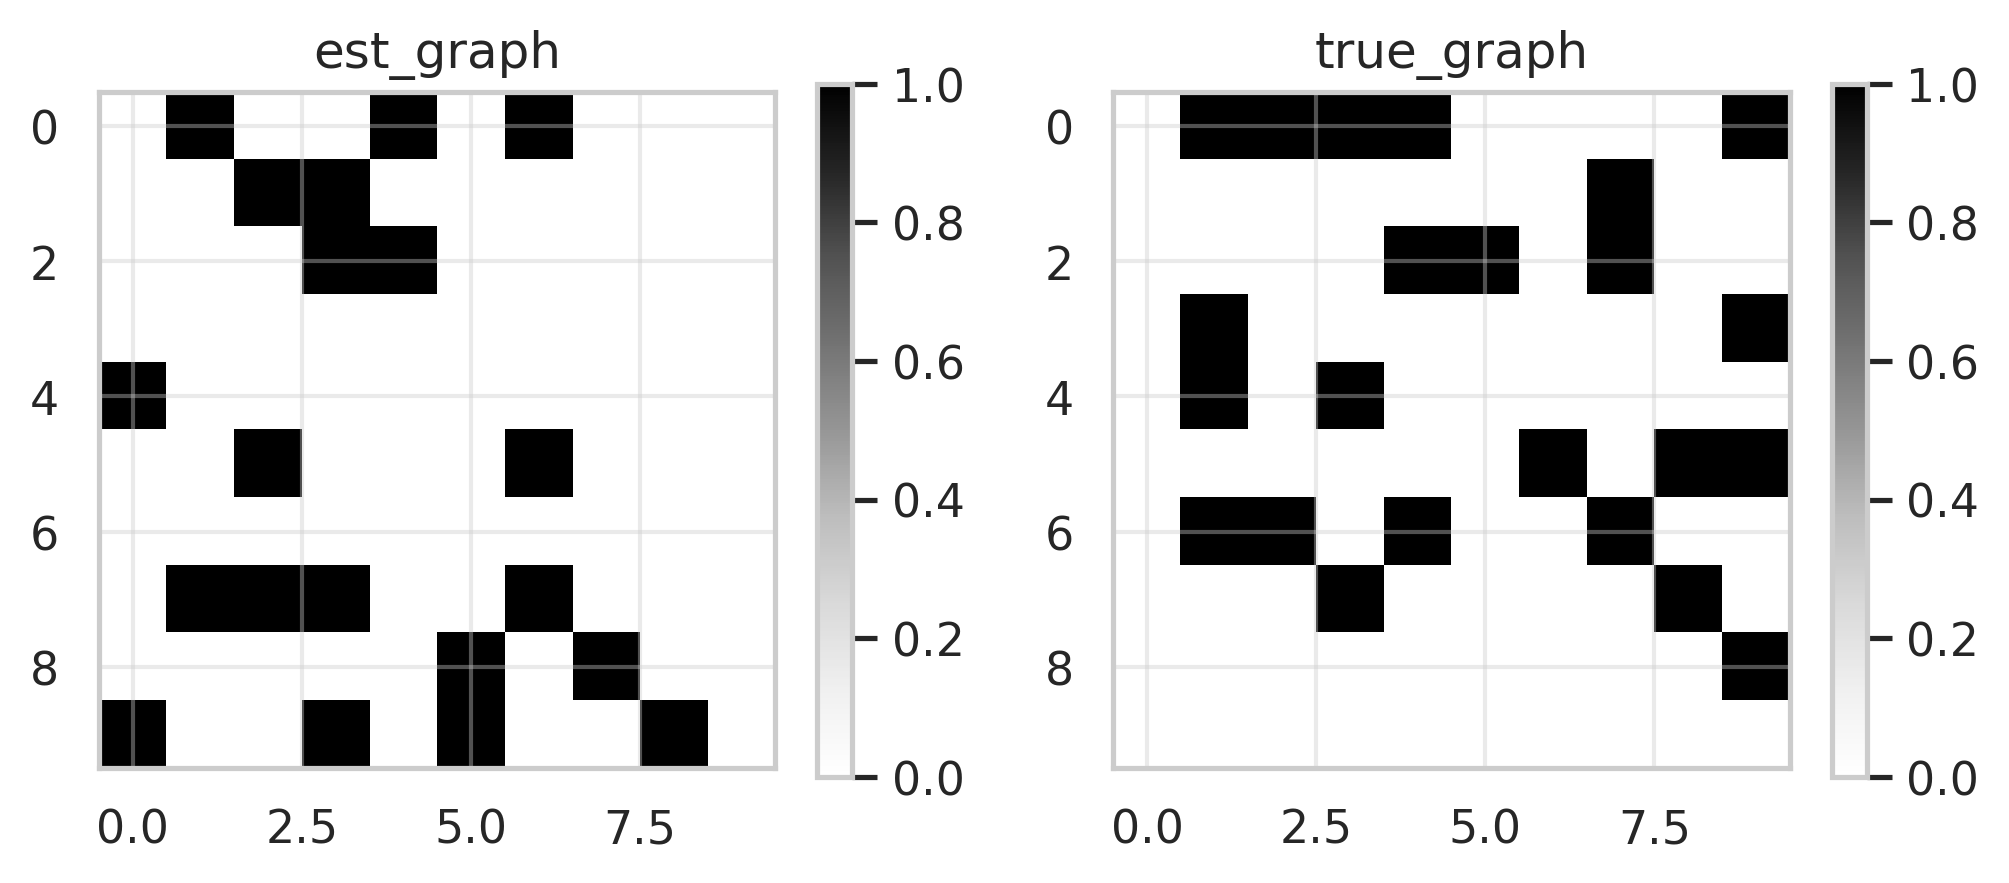

{'fdr': 0.7368, 'tpr': 0.2174, 'fpr': 0.6364, 'shd': 21, 'nnz': 19, 'precision': 0.2632, 'recall': 0.2174, 'F1': 0.2381, 'gscore': 0.0}


In [18]:
# benchmark model 2 dglearn
from dglearn import *

# learn structure using tabu search, plot learned structure
tabu_length = 4
patience = 4
max_iter = 10

manager = CyclicManager(X, bic_coef=0.5)
dglearn_B_est, best_score, log = tabu_search(manager, tabu_length, patience, max_iter=max_iter, first_ascent=False, verbose=1) # returns a binary matrix as learned support

# perform virtual edge correction
print("virtual edge correction...")
dglearn_B_est = virtual_refine(manager, dglearn_B_est, patience=0, max_iter=max_iter, max_path_len=6, verbose=1)

# remove any reducible edges
dglearn_B_est = reduce_support(dglearn_B_est, fill_diagonal=False)
# convert dglearn_B_est to boolean matrix in case it is not
dglearn_B_est = dglearn_B_est.astype(bool).T # Transpose to make each row correspond to parents

# plot est_dag and true_dag
GraphDAG(dglearn_B_est, B_true)
# calculate accuracy
met_dglearn = MetricsDAG(dglearn_B_est, B_true)
print(met_dglearn.metrics)

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


FRP time:  15.588004350662231
FRP edges:  29
FRP score:  0.028779921841812682
Current time:  2025-01-29 00:35:49.842391


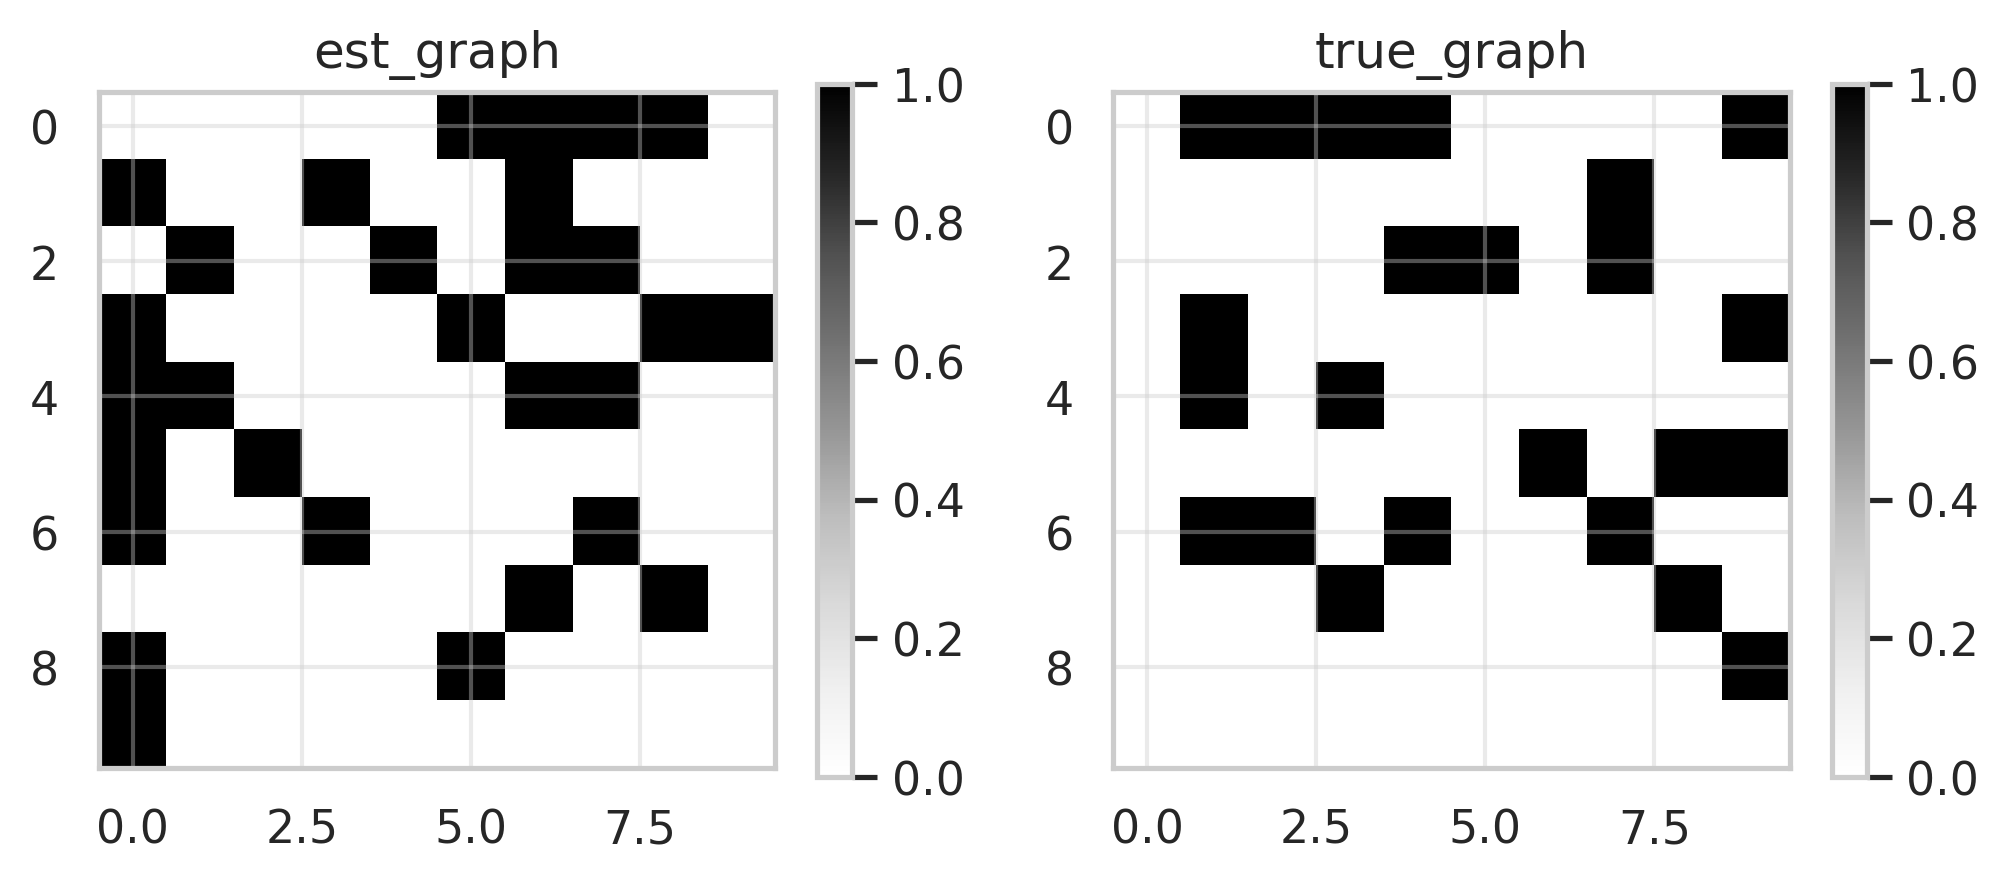

{'fdr': 0.76, 'tpr': 0.2609, 'fpr': 0.8636, 'shd': 26, 'nnz': 25, 'precision': 0.24, 'recall': 0.2609, 'F1': 0.25, 'gscore': 0.0}


In [19]:
# benchmark model 3 FRP

edge_penalty = 0.5 * np.log(X.shape[0]) / X.shape[0] # BIC choice
# Run FRP
frp_result = run_filter_rank_prune(
        X, 
        loss_type="kld",
        reg_type="scad",
        reg_params={"lam": edge_penalty, "gamma": 3.7},
		edge_penalty=edge_penalty,
        n_inits=1,
        n_threads=1,
        parcorr_thrs=0.1 * (X.shape[0] / 1000)**(-1/4),
        use_loss_cache=True,
        seed=seed,
        verbose=True,
)

frp_B_est = frp_result["learned_support"].T # Transpose to make each row correspond to parents

# plot est_dag and true_dag
GraphDAG(frp_B_est, B_true)
# calculate accuracy
met_frp = MetricsDAG(frp_B_est, B_true)
print(met_frp.metrics)

In [20]:
# Show metrics of all models (ours, LiNG, dglearn, FRP)

# use the function compute_model_fit to get the BIC and AIC scores for our method
bic_our, aic_our = compute_model_fit(B_est, X)
bic_ling, aic_ling = compute_model_fit(W_ling, X) # use W_ling otherwise we get -inf for bic and aic
bic_dglearn, aic_dglearn = compute_model_fit(dglearn_B_est, X)
bic_frp, aic_frp = compute_model_fit(frp_B_est, X)

print(f"BIC and AIC scores for our method: {bic_our:.3f}, {aic_our:.3f}")
print(f"BIC and AIC scores for LinG method: {bic_ling:.3f}, {aic_ling:.3f}")
print(f"BIC and AIC scores for dglearn method: {bic_dglearn:.3f}, {aic_dglearn:.3f}")
print(f"BIC and AIC scores for FRP method: {bic_frp:.3f}, {aic_frp:.3f}")

# Compute SHD and cycle F1 for all methods
cycle_shd_our = compute_cycle_SHD(B_true_EC, B_est)
cycle_shd_ling = compute_cycle_SHD(B_true_EC, ling_B_est)  # LinG method
cycle_shd_dglearn = compute_cycle_SHD(B_true_EC, dglearn_B_est)  # dglearn method
cycle_shd_frp = compute_cycle_SHD(B_true_EC, frp_B_est)  # FRP method

# B or B.T can be used for cycle F1, it doesn't matter
cycle_f1_our = compute_cycle_F1(B_true, B_est, verbose=True)
cycle_f1_ling = compute_cycle_F1(B_true, ling_B_est, verbose=True)
cycle_f1_dglearn = compute_cycle_F1(B_true, dglearn_B_est, verbose=True)
cycle_f1_frp = compute_cycle_F1(B_true, frp_B_est, verbose=True)

# Print SHD and cycle F1 scores
print(f"SHD cyclic and cycle F1 using our method: {cycle_shd_our}, {cycle_f1_our}")
print(f"SHD cyclic and cycle F1 using LinG method: {cycle_shd_ling}, {cycle_f1_ling}")
print(f"SHD cyclic and cycle F1 using dglearn method: {cycle_shd_dglearn}, {cycle_f1_dglearn}")
print(f"SHD cyclic and cycle F1 using FRP method: {cycle_shd_frp}, {cycle_f1_frp}")

# compute_CSS using compute_CSS(shd_cyclic, cycle_f1, epsilon=1e-8)
css_our = compute_CSS(cycle_shd_our, cycle_f1_our, epsilon=1e-8)
css_ling = compute_CSS(cycle_shd_ling, cycle_f1_ling, epsilon=1e-8)
css_dglearn = compute_CSS(cycle_shd_dglearn, cycle_f1_dglearn, epsilon=1e-8)
css_frp = compute_CSS(cycle_shd_frp, cycle_f1_frp, epsilon=1e-8)

# Print CSS scores
print(f"CSS using our method: {css_our}")
print(f"CSS using LinG method: {css_ling}")
print(f"CSS using dglearn method: {css_dglearn}")
print(f"CSS using FRP method: {css_frp}")

# now use the function compute_cycle_KLD to compute the cycle KLD for our method and all benchmark methods
# the signature of the function is compute_cycle_KLD(true_prec_mat, B_est, thresh=1e-6, max_iters=50, patience=10, verbose=False):

# for our method
cycle_kld_our = compute_cycle_KLD(prec_matrix, B_est)[0]
cycle_kld_ling = compute_cycle_KLD(prec_matrix, ling_B_est)[0]
cycle_kld_dglearn = compute_cycle_KLD(prec_matrix, dglearn_B_est)[0]
cycle_kld_frp = compute_cycle_KLD(prec_matrix, frp_B_est)[0]

# print the cycle KLD scores
print(f"Cycle KLD using our method: {cycle_kld_our}")
print(f"Cycle KLD using LinG method: {cycle_kld_ling}")
print(f"Cycle KLD using dglearn method: {cycle_kld_dglearn}")
print(f"Cycle KLD using FRP method: {cycle_kld_frp}")

BIC and AIC scores for our method: 21.781, -43.391
BIC and AIC scores for LinG method: 41.712, -23.460
BIC and AIC scores for dglearn method: 16.005, -36.133
BIC and AIC scores for FRP method: 47.212, -17.960
True cycles: [[2, 5, 6], [1, 7, 3]]
Estimated cycles: [[0, 1, 4], [0, 4], [0, 6], [0, 6, 3, 1, 4], [0, 6, 3, 7, 1, 4], [0, 6, 3, 8, 7, 1, 4], [0, 6, 3, 9, 8, 7, 1, 4], [0, 6, 4], [0, 6, 5, 8, 7, 1, 4], [0, 6, 5, 8, 7, 3, 1, 4], [0, 6, 5, 9, 8, 7, 1, 4], [0, 6, 5, 9, 8, 7, 3, 1, 4], [0, 6, 7, 1, 4], [0, 6, 7, 3, 1, 4], [0, 9, 8, 7, 1, 4], [0, 9, 8, 7, 3, 1, 4], [1, 3], [1, 3, 7], [1, 3, 8, 7], [1, 3, 9, 8, 7], [1, 4], [1, 4, 2], [1, 4, 2, 5, 8, 7], [1, 4, 2, 5, 8, 7, 3], [1, 4, 2, 5, 9, 8, 7], [1, 4, 2, 5, 9, 8, 7, 3], [1, 4, 2, 7], [1, 4, 2, 7, 3], [2, 4], [3, 7], [3, 8, 7], [3, 9, 8, 7], [8, 5], [8, 5, 9], [8, 7], [8, 9]]
True cycles: [[2, 5, 6], [1, 7, 3]]
Estimated cycles: [[0, 1, 2], [0, 1, 2, 4], [0, 1, 2, 4, 6, 7], [0, 1, 2, 4, 6, 7, 3], [0, 1, 2, 4, 6, 7, 3, 9], [0, 1, 2, 4

In [20]:
################################################ MISC NON CYCLIC MODELS ################################################

In [ ]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import GOLEM

# GOLEM learn
#gol = GOLEM(num_iter=2e4, lambda_2=1e4/X.shape[1], lambda_1=1e-2)
#gol = GOLEM(num_iter=2e4, lambda_2=0.0)  setting h_reg to 0 still allows model to be fit (no error thrown)
gol = GOLEM(num_iter=2e4, non_equal_variances=True, lambda_1=1e-2) # F1 of 60%
#g = GOLEM(num_iter=2e4, non_equal_variances=False) # F1 of 68%, default non_equal_variances=True
gol.learn(X)

# plot est_dag and true_dag
GraphDAG(gol.causal_matrix, B_true)

# calculate accuracy
gol_met = MetricsDAG(gol.causal_matrix, B_true)
print(gol_met.metrics)
print("The number of edges in golem graph: ", np.sum(gol.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms import Notears

# notears learn
nt = Notears(lambda1=1e-3, h_tol=1e-5, max_iter=100) # default loss_type is 'l2', F1 of 27%
#nt = Notears(lambda1=1e-2, h_tol=1e-5, max_iter=10000, loss_type='logistic')
#nt = Notears(lambda1=1e-2, h_tol=1e-5, max_iter=10000, loss_type='poisson')
nt.learn(X)

# plot est_dag and true_dag
GraphDAG(nt.causal_matrix, B_true)

# calculate accuracy
nt_met = MetricsDAG(nt.causal_matrix, B_true)
print(nt_met.metrics)
print("The number of edges in notears graph: ", np.sum(nt.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms import PC

# A variant of PC-algorithm, one of [`original`, `stable`, `parallel`]
pc = PC(variant='parallel', alpha=0.05, ci_test='fisherz') # F1 of 15%
#pc = PC(variant='stable', alpha=0.05) # F1 of 17%
#pc = PC(variant='original', alpha=0.05) # F1 of 19%
pc.learn(X)

# plot est_dag and true_dag
GraphDAG(pc.causal_matrix, B_true)

# calculate accuracy
pc_met = MetricsDAG(pc.causal_matrix, B_true)
print(pc_met.metrics)
print("The number of edges in pc graph: ", np.sum(pc.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms.ges.ges import GES

# GES learn
# method is one of ['r2', 'scatter']
ges = GES() # F1 of 42%
#ges = GES(criterion='bic', method='scatter') # F1 of 47%
#ges = GES(criterion='bic', method='r2') # F1 of 4%

# learn the graph structure
# create X_ges that adds noise to X because GES complains about singular matrix
X_ges = X + np.random.normal(0, 1, X.shape)**4
ges.learn(X)

# plot est_dag and true_dag
GraphDAG(ges.causal_matrix, B_true)

# calculate accuracy
ges_met = MetricsDAG(ges.causal_matrix, B_true)
print(ges_met.metrics)
print("The number of edges in ges graph: ", np.sum(ges.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms import DirectLiNGAM

# measure : {'pwling', 'kernel'}, default='pwling'
g_ling = DirectLiNGAM(measure='pwling') # F1 of 74%
#g = DirectLiNGAM(measure='kernel') # F1 of nan - takes too long to run (even after 15 minutes not done)
g_ling.learn(X)

# plot est_dag and true_dag
GraphDAG(g_ling.causal_matrix, B_true)

# calculate accuracy
g_ling_met = MetricsDAG(g_ling.causal_matrix, B_true)
print(g_ling_met.metrics)
print("The number of edges in directlingam graph: ", np.sum(g_ling.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms import ICALiNGAM

# ICALiNGAM learn
# max_iter : int, optional (default=1000)
#g = ICALiNGAM(max_iter=1000) # F1 of 48%
g_ica = ICALiNGAM(max_iter=100000) # F1 of 51%
g_ica.learn(X)

# plot est_dag and true_dag
GraphDAG(g_ica.causal_matrix, B_true)

# calculate accuracy
g_ica_met = MetricsDAG(g_ica.causal_matrix, B_true)
print(g_ica_met.metrics)
print("The number of edges in ica graph: ", np.sum(g_ica.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
#shd_dg = min_colperm_shd(equiv_class, learned_support) # dglearn
#print("SHD to nearest member of equivalence class using dglearn: %d" % shd_dg)

# print compute_cycle_SHD and compute_cycle_F1 for all methods, usage: compute_cycle_F1(B_true, B_est), directly print both with method name in single line
shd_our = compute_cycle_SHD(B_true_EC, B_est) # our method
shd_gol = compute_cycle_SHD(B_true_EC, gol.causal_matrix) # golem
shd_nt = compute_cycle_SHD(B_true_EC, nt.causal_matrix) # notears
shd_icag = compute_cycle_SHD(B_true_EC, g_ica.causal_matrix) # icalingam
shd_ling = compute_cycle_SHD(B_true_EC, g_ling.causal_matrix) # lingam

cycle_f1_our = compute_cycle_F1(B_true, B_est, verbose=True)
cycle_f1_gol = compute_cycle_F1(B_true, gol.causal_matrix, verbose=True)
cycle_f1_nt = compute_cycle_F1(B_true, nt.causal_matrix, verbose=True)
cycle_f1_icag = compute_cycle_F1(B_true, g_ica.causal_matrix, verbose=True)
cycle_f1_ling = compute_cycle_F1(B_true, g_ling.causal_matrix, verbose=True)

print(f"SHD cyclic and cycle F1 using our method: {shd_our}, {cycle_f1_our}")
print(f"SHD cyclic and cycle F1 using golem: {shd_gol}, {cycle_f1_gol}")
print(f"SHD cyclic and cycle F1 using notears: {shd_nt}, {cycle_f1_nt}")
print(f"SHD cyclic and cycle F1 using icalingam: {shd_icag}, {cycle_f1_icag}")
print(f"SHD cyclic and cycle F1 using lingam: {shd_ling}, {cycle_f1_ling}")

In [ ]:
from dglearn import *

# learn structure using tabu search, plot learned structure
tabu_length = X.shape[1] # number of variables
patience = 5

manager = CyclicManager(X, bic_coef=0.5)
learned_support, best_score, log = tabu_search(manager, tabu_length, patience, first_ascent=False, verbose=1) # returns a binary matrix as learned support
# the above does not finish running (within 2 hours) for a graph with 15 nodes and 4000 samples # need to run overnight

In [ ]:
# perform virtual edge correction
print("virtual edge correction...")
learned_support = virtual_refine(manager, learned_support, patience=0, max_path_len=6, verbose=1)

# remove any reducible edges
learned_support = reduce_support(learned_support, fill_diagonal=False)

In [ ]:
# plot est_dag and true_dag
GraphDAG(learned_support, B_true)

# calculate accuracy
dg_met = MetricsDAG(learned_support, B_true)
print(dg_met.metrics)

In [ ]:
# get edge list from B_true using networkx
G_true = nx.DiGraph(B_true)
edges_true = list(G_true.edges())
# compute performance metric: SHD
true_graph = AdjacencyStucture(X.shape[1], edges_true)
search = GraphEquivalenceSearch(true_graph)
search.search_dfs()
equiv_class = [binary2array(bstr) for bstr in search.visited_graphs]
#shd_dg = min_colperm_shd(equiv_class, learned_support) # dglearn
shd_our = min_colperm_shd(equiv_class, B_est) # our method
shd_gol = min_colperm_shd(equiv_class, gol.causal_matrix) # golem
shd_nt = min_colperm_shd(equiv_class, nt.causal_matrix) # notears
shd_icag = min_colperm_shd(equiv_class, g_ica.causal_matrix) # icalingam
shd_ling = min_colperm_shd(equiv_class, g_ling.causal_matrix) # lingam
#print("SHD to nearest member of equivalence class using dglearn: %d" % shd_dg)
print("SHD to nearest member of equivalence class using our method: %d" % shd_our)
print("SHD to nearest member of equivalence class using golem: %d" % shd_gol)
print("SHD to nearest member of equivalence class using notears: %d" % shd_nt)
print("SHD to nearest member of equivalence class using icalingam: %d" % shd_icag)
print("SHD to nearest member of equivalence class using lingam: %d" % shd_ling)

In [ ]:
print("Number of graphs in the equivalence class: %d" % len(B_true_EC))